In [321]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import seaborn as sns
import os, random, numpy as np, tensorflow as tf

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


df = pd.read_csv('nba_2022-23_stats.csv')

print(df.head())
print(df.dtypes)
print(df.describe())

   Unnamed: 0        Player Name    Salary Position  Age     Team  GP  GS  \
0           0      Stephen Curry  48070014       PG   34      GSW  56  56   
1           1          John Wall  47345760       PG   32      LAC  34   3   
2           2  Russell Westbrook  47080179       PG   34  LAL/LAC  73  24   
3           3       LeBron James  44474988       PF   38      LAL  55  54   
4           4       Kevin Durant  44119845       PF   34  BRK/PHO  47  47   

     MP    FG  ...  TOV%  USG%  OWS  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP  
0  34.7  10.0  ...  12.5  31.0  5.8  2.0  7.8  0.192   7.5   0.1  7.5   4.7  
1  22.2   4.1  ...  17.1  27.0 -0.4  0.7  0.3  0.020  -0.8  -0.4 -1.2   0.1  
2  29.1   5.9  ...  18.4  27.7 -0.6  2.6  1.9  0.044   0.3  -0.1  0.2   1.2  
3  35.5  11.1  ...  11.6  33.3  3.2  2.4  5.6  0.138   5.5   0.6  6.1   4.0  
4  35.6  10.3  ...  13.4  30.7  4.7  2.1  6.8  0.194   6.0   1.2  7.1   3.9  

[5 rows x 52 columns]
Unnamed: 0         int64
Player Name       obj

Question 1 - Data Cleaning

In [322]:
dfCleaned = df.copy()

Checks for non-numeric fields

In [323]:
nonNumericMask = pd.to_numeric(dfCleaned['3P'], errors='coerce').isna() & dfCleaned['3P'].notna()
nonNumericIdx = dfCleaned.index[nonNumericMask]
print(f"Non-numeric entries in 3P: {nonNumericMask.sum()}")

if nonNumericMask.any():
    print(dfCleaned.loc[nonNumericIdx, ['Player Name', '3P', '3PA', '3P%']].head())

#Reconstruct 3P
has_parts = nonNumericMask & dfCleaned['3PA'].notna() & dfCleaned['3P%'].notna()
dfCleaned.loc[has_parts, '3P'] = dfCleaned.loc[has_parts, '3PA'] * dfCleaned.loc[has_parts, '3P%']

#Convert the whole column to numeric, weird stuff goes to NaN
dfCleaned['3P'] = pd.to_numeric(dfCleaned['3P'], errors='coerce')

# Checks for non negative
dfCleaned['3P'] = dfCleaned['3P'].clip(lower=0)

Non-numeric entries in 3P: 1
    Player Name    3P  3PA    3P%
5  Bradley Beal  1.s6  4.4  0.365


Checks for missing values and adds NaNs in appropriate places

In [324]:
import numpy as np

def safe_div(num, den):
    # checks for deno, =0, num =0
    return np.where(den > 0, num/den,
                    np.where((den == 0) & (num == 0), 0.0, np.nan))

# Recompute proportions that truly live on 0..1
if {'FG','FGA'}.issubset(dfCleaned):   dfCleaned['FG%']  = safe_div(dfCleaned['FG'],  dfCleaned['FGA'])
if {'2P','2PA'}.issubset(dfCleaned):   dfCleaned['2P%']  = safe_div(dfCleaned['2P'],  dfCleaned['2PA'])
if {'3P','3PA'}.issubset(dfCleaned):   dfCleaned['3P%']  = safe_div(dfCleaned['3P'],  dfCleaned['3PA'])

# eFG% and TS%, cant exceed 1
if {'FG','3P','FGA'}.issubset(dfCleaned):
    dfCleaned['eFG%'] = safe_div(dfCleaned['FG'] + 0.5*dfCleaned['3P'], dfCleaned['FGA'])
if {'PTS','FGA','FTA'}.issubset(dfCleaned):
    denom = 2*(dfCleaned['FGA'] + 0.44*dfCleaned['FTA'])
    dfCleaned['TS%'] = safe_div(dfCleaned['PTS'], denom)

if {'3PA','FGA'}.issubset(dfCleaned):  dfCleaned['3PAr'] = safe_div(dfCleaned['3PA'], dfCleaned['FGA'])
if {'FTA','FGA'}.issubset(dfCleaned):  dfCleaned['FTr']  = safe_div(dfCleaned['FTA'], dfCleaned['FGA'])

missingCount = dfCleaned.isna().sum()
missingPercent = (missingCount / len(dfCleaned)) * 100
missingDf = (pd.DataFrame({'Missing Count': missingCount, 'Percentage': missingPercent})
               .query('`Missing Count` > 0')
               .sort_values('Missing Count', ascending=False))
print(missingDf.head(20))

     Missing Count  Percentage
FT%             23    4.925054


Scaling and keeps values between 0 and 1

In [325]:
prop_01 = ['FG%', '2P%', '3P%', 'eFG%', 'TS%', '3PAr']  # values go from 0 to 1
pct_0_100 = ['ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%']  # values go from 0 to 100
ftr_col = 'FTr'  # not a percentage and is a ratio, so values can be above 1

# Making everything the same scale, 0 to 1
for col in pct_0_100:
    if col in dfCleaned.columns:
        q75 = dfCleaned[col].quantile(0.75)
        mx  = dfCleaned[col].max()
        if (q75 > 1) and (mx <= 100):
            dfCleaned[col] = dfCleaned[col] / 100.0

issues = {}

expect_01 = [c for c in prop_01 + pct_0_100 if c in dfCleaned.columns]
for col in expect_01:
    m = (dfCleaned[col] < 0) | (dfCleaned[col] > 1)
    if m.any():
        issues[col] = {
            'scale': '[0,1]',
            'rows': dfCleaned.index[m].tolist(),
            'values': dfCleaned.loc[m, col].tolist()
        }

# FTr: only check non-negativity
if ftr_col in dfCleaned.columns:
    m = dfCleaned[ftr_col] < 0
    if m.any():
        issues[ftr_col] = {
            'scale': '>= 0 (can exceed 1)',
            'rows': dfCleaned.index[m].tolist(),
            'values': dfCleaned.loc[m, ftr_col].tolist()
        }

# TS%, just checks values that are greater than 1
if 'TS%' in dfCleaned.columns:
    m = dfCleaned['TS%'] > 1
    if m.any():
        print("Note: TS% slightly > 1 for rows (tiny-sample edge cases likely):",
              dfCleaned.index[m].tolist()[:15])

if issues:
    print("Out-of-range values after normalization:")
    for col, info in issues.items():
        rows, vals = info['rows'], info['values']
        print(f"  {col} expected {info['scale']} — {len(rows)} rows")
        print(f"    rows: {rows[:10]}{' ...' if len(rows)>10 else ''}")
        print(f"    vals: {vals[:10]}{' ...' if len(vals)>10 else ''}")
else:
    print("All percentage/rate columns are within expected ranges (with FTr allowed > 1).")

dfCleaned[expect_01].describe().T[['min','max']]

Note: TS% slightly > 1 for rows (tiny-sample edge cases likely): [441]
Out-of-range values after normalization:
  TS% expected [0,1] — 1 rows
    rows: [441]
    vals: [1.069078947368421]


,min,max
FG%,0.000,1.000000
2P%,0.000,1.000000
3P%,0.000,1.000000
eFG%,0.000,1.000000
TS%,0.000,1.069079
3PAr,0.000,1.000000
ORB%,0.000,0.288000
DRB%,0.000,0.554000
TRB%,0.000,0.296000
AST%,0.000,0.476000


Checks for duplicate rows, negative values for ratios and flags calculation problems

In [326]:
# duplicate rows
dupe_n = dfCleaned.duplicated().sum()
print(f"Duplicate rows: {dupe_n}")
if dupe_n > 0:
    dfCleaned = dfCleaned.drop_duplicates()
    print("Duplicates dropped.")

# negative values before 
count_cols = ['GP','GS','MP','FG','FGA','3P','3PA','2P','2PA','FT','FTA',
              'ORB','DRB','TRB','AST','STL','BLK','TOV','PF','PTS']
present_counts = [c for c in count_cols if c in dfCleaned.columns]
neg_before = (dfCleaned[present_counts] < 0).sum().sum()
print(f"Negative entries (counts) before fix: {neg_before}")

dfCleaned[present_counts] = dfCleaned[present_counts].clip(lower=0)

neg_after = (dfCleaned[present_counts] < 0).sum().sum()
print(f"Negative entries (counts) after fix:  {neg_after}")

# Flags problems with calculations
problems = {}

def flag(name, mask):
    if mask.any():
        problems[name] = dfCleaned.index[mask].tolist()

if {'FG','2P','3P'}.issubset(dfCleaned):
    flag('FG != 2P + 3P', dfCleaned['FG'] != (dfCleaned['2P'] + dfCleaned['3P']))

if {'FGA','2PA','3PA'}.issubset(dfCleaned):
    flag('FGA != 2PA + 3PA', dfCleaned['FGA'] != (dfCleaned['2PA'] + dfCleaned['3PA']))

if {'3P','3PA'}.issubset(dfCleaned):
    flag('3P > 3PA', dfCleaned['3P'] > dfCleaned['3PA'])

if {'2P','2PA'}.issubset(dfCleaned):
    flag('2P > 2PA', dfCleaned['2P'] > dfCleaned['2PA'])

if {'GS','GP'}.issubset(dfCleaned):
    flag('GS > GP', dfCleaned['GS'] > dfCleaned['GP'])

if problems:
    print("\nLogical identity violations detected:")
    for k, idxs in problems.items():
        print(f"  {k}: {len(idxs)} rows (e.g., {idxs[:10]}{' ...' if len(idxs)>10 else ''})")
else:
    print("\nAll core identities satisfied.")

import numpy as np
def safe_div(num, den):
    return np.where(den > 0, num/den, np.where((den==0)&(num==0), 0.0, np.nan))

if {'FG','FGA'}.issubset(dfCleaned):   dfCleaned['FG%']  = safe_div(dfCleaned['FG'],  dfCleaned['FGA'])
if {'2P','2PA'}.issubset(dfCleaned):   dfCleaned['2P%']  = safe_div(dfCleaned['2P'],  dfCleaned['2PA'])
if {'3P','3PA'}.issubset(dfCleaned):   dfCleaned['3P%']  = safe_div(dfCleaned['3P'],  dfCleaned['3PA'])
if {'FG','3P','FGA'}.issubset(dfCleaned): dfCleaned['eFG%'] = safe_div(dfCleaned['FG'] + 0.5*dfCleaned['3P'], dfCleaned['FGA'])
if {'PTS','FGA','FTA'}.issubset(dfCleaned):
    denom = 2*(dfCleaned['FGA'] + 0.44*dfCleaned['FTA'])
    dfCleaned['TS%'] = safe_div(dfCleaned['PTS'], denom)
if {'3PA','FGA'}.issubset(dfCleaned):  dfCleaned['3PAr'] = safe_div(dfCleaned['3PA'], dfCleaned['FGA'])
if {'FTA','FGA'}.issubset(dfCleaned):  dfCleaned['FTr']  = safe_div(dfCleaned['FTA'], dfCleaned['FGA'])


Duplicate rows: 0
Negative entries (counts) before fix: 0
Negative entries (counts) after fix:  0

Logical identity violations detected:
  FG != 2P + 3P: 147 rows (e.g., [3, 5, 9, 10, 13, 14, 23, 24, 26, 30] ...)
  FGA != 2PA + 3PA: 157 rows (e.g., [0, 3, 6, 9, 10, 17, 19, 20, 23, 25] ...)


Fixes calculation problems

In [327]:
import numpy as np

dfc = dfCleaned  

mask_gp = dfc['GP'] > 0

# makse integer totals from per-game rates
def to_tot(col_pg):  
    return np.rint(dfc.loc[mask_gp, col_pg] * dfc.loc[mask_gp, 'GP']).astype('Int64')

# Build totals where components exist
have_shot_parts   = mask_gp & dfc[['2P','3P']].notna().all(axis=1)
have_attempts     = mask_gp & dfc[['2PA','3PA']].notna().all(axis=1)

# Current totals (rounded from per-game)
FG_tot  = to_tot('FG')
FGA_tot = to_tot('FGA')
P2_tot  = to_tot('2P')
P3_tot  = to_tot('3P')
PA2_tot = to_tot('2PA')
PA3_tot = to_tot('3PA')

#  Makes: FG_tot := 2P_tot + 3P_tot
fix_makes_mask = have_shot_parts
FG_tot.loc[fix_makes_mask] = (P2_tot + P3_tot).loc[fix_makes_mask]

# FGA_tot := 2PA_tot + 3PA_tot
fix_atts_mask = have_attempts
FGA_tot.loc[fix_atts_mask] = (PA2_tot + PA3_tot).loc[fix_atts_mask]

# Push totals back to per-game, where GP>0
gp = dfc.loc[mask_gp, 'GP'].astype(float)
dfc.loc[mask_gp, 'FG']  = FG_tot.astype('float64')  / gp
dfc.loc[mask_gp, 'FGA'] = FGA_tot.astype('float64') / gp

# re-derives 2P/3P per-game from totals for consistency
dfc.loc[mask_gp, '2P']  = P2_tot.astype('float64')  / gp
dfc.loc[mask_gp, '3P']  = P3_tot.astype('float64')  / gp
dfc.loc[mask_gp, '2PA'] = PA2_tot.astype('float64') / gp
dfc.loc[mask_gp, '3PA'] = PA3_tot.astype('float64') / gp

# Recompute percentage/rate columns after adjustments
def safe_div(num, den):
    return np.where(den > 0, num/den, np.where((den==0)&(num==0), 0.0, np.nan))

if {'FG','FGA'}.issubset(dfc):   dfc['FG%']  = safe_div(dfc['FG'],  dfc['FGA'])
if {'2P','2PA'}.issubset(dfc):   dfc['2P%']  = safe_div(dfc['2P'],  dfc['2PA'])
if {'3P','3PA'}.issubset(dfc):   dfc['3P%']  = safe_div(dfc['3P'],  dfc['3PA'])
if {'FG','3P','FGA'}.issubset(dfc):
    dfc['eFG%'] = safe_div(dfc['FG'] + 0.5*dfc['3P'], dfc['FGA'])
if {'PTS','FGA','FTA'}.issubset(dfc):
    denom = 2*(dfc['FGA'] + 0.44*dfc['FTA'])
    dfc['TS%'] = safe_div(dfc['PTS'], denom)
if {'3PA','FGA'}.issubset(dfc):  dfc['3PAr'] = safe_div(dfc['3PA'], dfc['FGA'])
if {'FTA','FGA'}.issubset(dfc):  dfc['FTr']  = safe_div(dfc['FTA'], dfc['FGA'])

eps = 1e-6
m1 = (dfc['FG']  - (dfc['2P']  + dfc['3P'])).abs()  > eps
m2 = (dfc['FGA'] - (dfc['2PA'] + dfc['3PA'])).abs() > eps
print("After total-based correction:")
print("  FG ≈ 2P + 3P violations:", int(m1.sum()))
print("  FGA ≈ 2PA + 3PA violations:", int(m2.sum()))

After total-based correction:
  FG ≈ 2P + 3P violations: 0
  FGA ≈ 2PA + 3PA violations: 0


Frequency Distribution of Numeric Columns

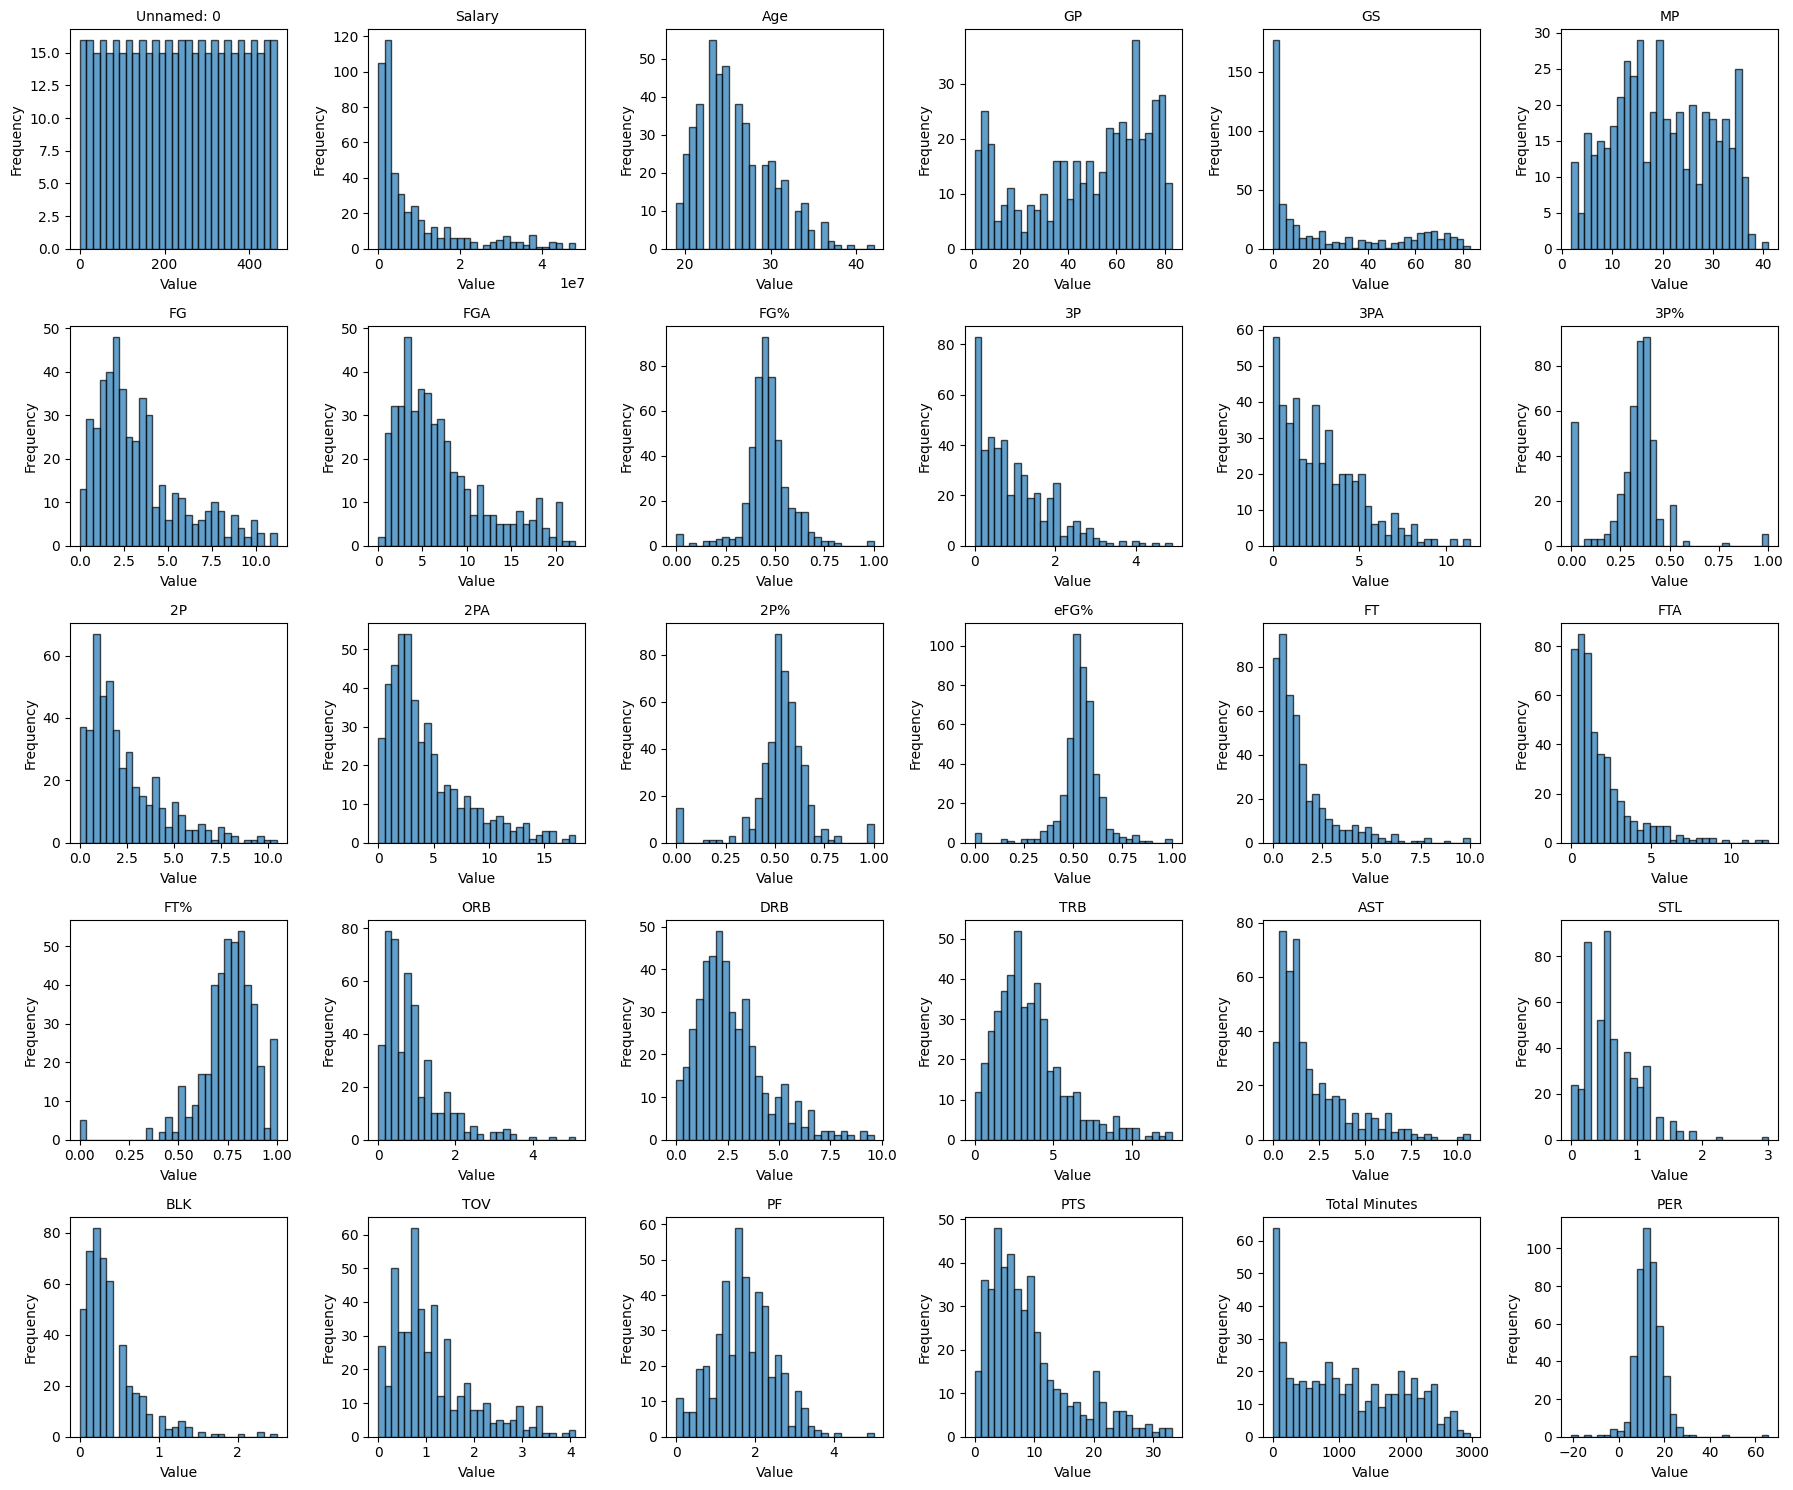

In [328]:
numericCols = dfCleaned.select_dtypes(include=[np.number]).columns
fig, axes = plt.subplots(5, 6, figsize=(18, 15))
axes = axes.flatten()

for idx, col in enumerate(numericCols[:30]):  # Show first 30 numeric columns
    axes[idx].hist(dfCleaned[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
    axes[idx].set_title(col, fontsize=10)
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Drop closely related columns, Stray NaNs and infs

In [329]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Recomputes ratio/percentage columns For no NaNs
def safe_div(num, den):
    return np.where(den > 0, num/den,
                    np.where((den == 0) & (num == 0), 0.0, np.nan))

# Only the ones in the dataset
if {'FG','FGA'}.issubset(dfCleaned):   dfCleaned['FG%']  = safe_div(dfCleaned['FG'],  dfCleaned['FGA'])
if {'2P','2PA'}.issubset(dfCleaned):   dfCleaned['2P%']  = safe_div(dfCleaned['2P'],  dfCleaned['2PA'])
if {'3P','3PA'}.issubset(dfCleaned):   dfCleaned['3P%']  = safe_div(dfCleaned['3P'],  dfCleaned['3PA'])

if {'FG','3P','FGA'}.issubset(dfCleaned):
    dfCleaned['eFG%'] = safe_div(dfCleaned['FG'] + 0.5*dfCleaned['3P'], dfCleaned['FGA'])

if {'PTS','FGA','FTA'}.issubset(dfCleaned):
    denom = 2*(dfCleaned['FGA'] + 0.44*dfCleaned['FTA'])
    dfCleaned['TS%'] = safe_div(dfCleaned['PTS'], denom)

if {'3PA','FGA'}.issubset(dfCleaned):  dfCleaned['3PAr'] = safe_div(dfCleaned['3PA'], dfCleaned['FGA'])
if {'FTA','FGA'}.issubset(dfCleaned):  dfCleaned['FTr']  = safe_div(dfCleaned['FTA'], dfCleaned['FGA'])

# Removes NaNs
ratio_cols = ['FG%', '2P%', '3P%', 'eFG%', 'TS%', '3PAr', 'FTr']
ratio_cols = [c for c in ratio_cols if c in dfCleaned.columns]

for c in ratio_cols:
    dfCleaned[c] = dfCleaned[c].clip(0, 1)

dfCleaned[ratio_cols] = dfCleaned[ratio_cols].fillna(0.0)

# when makes >0 and attempts are =0
if {'3P','3PA','3P%'}.issubset(dfCleaned.columns):
    impossible_3p = (dfCleaned['3PA'] == 0) & (dfCleaned['3P'] > 0)
    if impossible_3p.any():
        dfCleaned.loc[impossible_3p, '3P%'] = dfCleaned['3P%'].median()

# Replace any stray infs anywhere
dfCleaned.replace([np.inf, -np.inf], np.nan, inplace=True)

# Cols that are not needed
dropCols = ["Player Name", "Team", "Position"]
dfNumeric = (dfCleaned.drop(columns=dropCols, errors="ignore")
                        .select_dtypes(include=[np.number]))

# Median impute is safe and won’t create huge bias like blanket zeros
dfNumeric = dfNumeric.apply(lambda s: s.fillna(s.median()))

# Check for NaNs
print("NaNs left:", int(dfNumeric.isna().sum().sum()),
      "Infs left:", int(np.isinf(dfNumeric.values).sum()))

# Scaking for AE
scaler = StandardScaler()
xScaled = scaler.fit_transform(dfNumeric)
xTrain, xTest = train_test_split(xScaled, test_size=0.2, random_state=42)


NaNs left: 0 Infs left: 0


Question 2.1 (a)

Autoencoder model

In [330]:
inputDimension = xTrain.shape[1]
encodingDimension = 2

inputDimension = xTrain.shape[1]
encodingDimension = 2

#Regularisation coefficients
lambda1 = 1e-5
lambda2 = 1e-4

encoder = models.Sequential([
    layers.Input(shape=(inputDimension,)),
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(lambda1)),
    layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(lambda2)),
    layers.Dense(encodingDimension)
])

decoder = models.Sequential([
    layers.Input(shape=(encodingDimension,)),
    layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(lambda2)),
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(lambda1)),
    layers.Dense(inputDimension, activation='linear')
])

autoencoder = models.Sequential([encoder, decoder])
autoencoder.compile(optimizer='adam', loss='mse')

Train Autoencoder

In [331]:
history = autoencoder.fit(
    xTrain, xTrain,
    epochs=50,
    batch_size=32,
    validation_data=(xTest, xTest),
    verbose=0
)

X_encoded = encoder.predict(xScaled)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


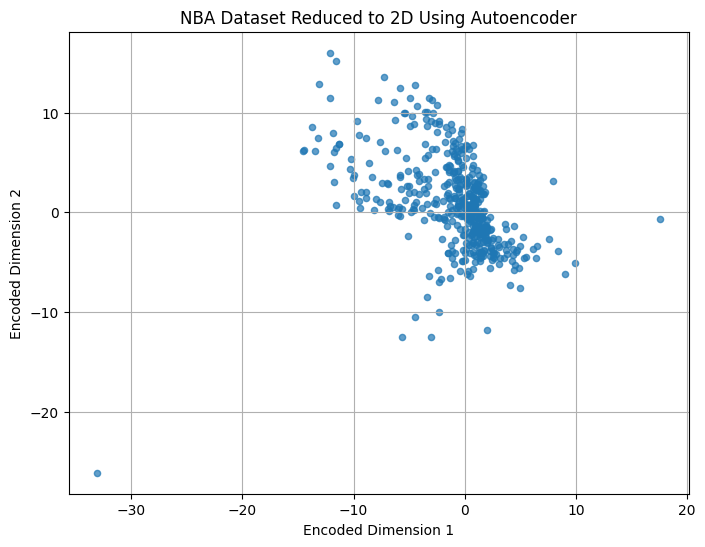

In [332]:
plt.figure(figsize=(8,6))
plt.scatter(X_encoded[:,0], X_encoded[:,1], s=20, alpha=0.7)
plt.title("NBA Dataset Reduced to 2D Using Autoencoder")
plt.xlabel("Encoded Dimension 1")
plt.ylabel("Encoded Dimension 2")
plt.grid(True)
plt.show()

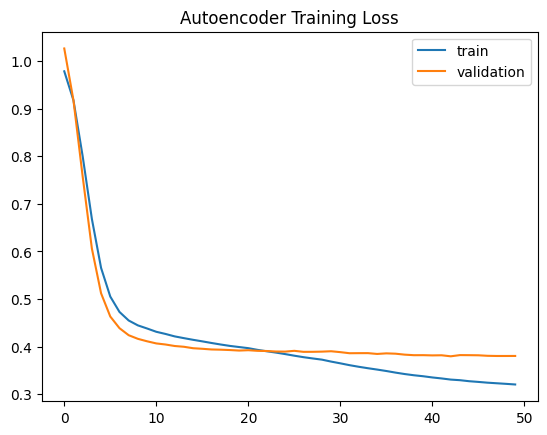

In [333]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title('Autoencoder Training Loss')
plt.show()


In [334]:
# Get reconstructed outputs
X_reconstructed = autoencoder.predict(xScaled)

# Compute Mean Squared Error (MSE) for each sample
reconstruction_errors = np.mean(np.square(xScaled - X_reconstructed), axis=1)

# Summary statistics
print("Mean reconstruction error:", np.mean(reconstruction_errors))
print("Std of reconstruction error:", np.std(reconstruction_errors))


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Mean reconstruction error: 0.3257687429563343
Std of reconstruction error: 0.3174290410969443


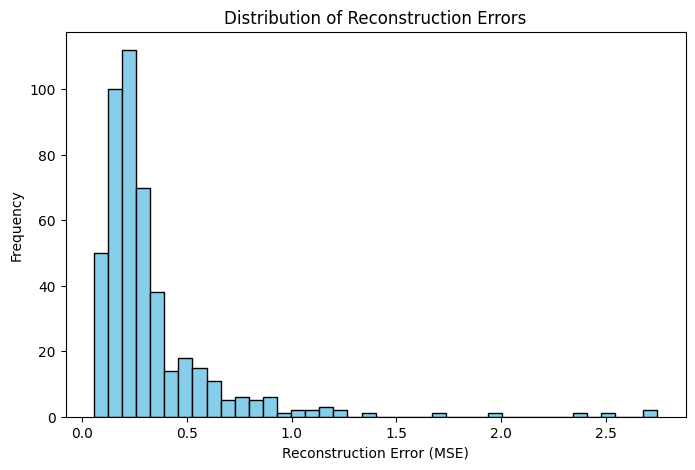

In [335]:
plt.figure(figsize=(8,5))
plt.hist(reconstruction_errors, bins=40, color='skyblue', edgecolor='k')
plt.title("Distribution of Reconstruction Errors")
plt.xlabel("Reconstruction Error (MSE)")
plt.ylabel("Frequency")
plt.show()


In [336]:
worst_idx = np.argsort(reconstruction_errors)[-5:]
df.iloc[worst_idx][["Player Name", "PTS", "Age", "Salary"]]


,Player Name,PTS,Age,Salary
433,Louis King,20.0,23,307089
458,Jordan Schakel,1.5,24,96514
437,Donovan Williams,2.0,21,239822
428,Chima Moneke,1.0,27,500000
439,Chris Silva,2.0,26,211045


Question 2.2 (a)

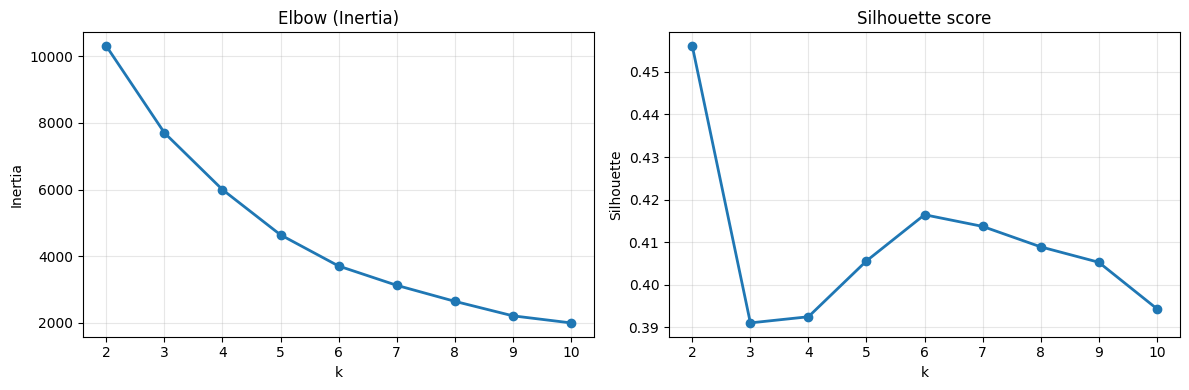

Silhouette by k:
  k=2: 0.456
  k=3: 0.391
  k=4: 0.392
  k=5: 0.406
  k=6: 0.416
  k=7: 0.414
  k=8: 0.409
  k=9: 0.405
  k=10: 0.394

Auto-selected k (max silhouette): 2


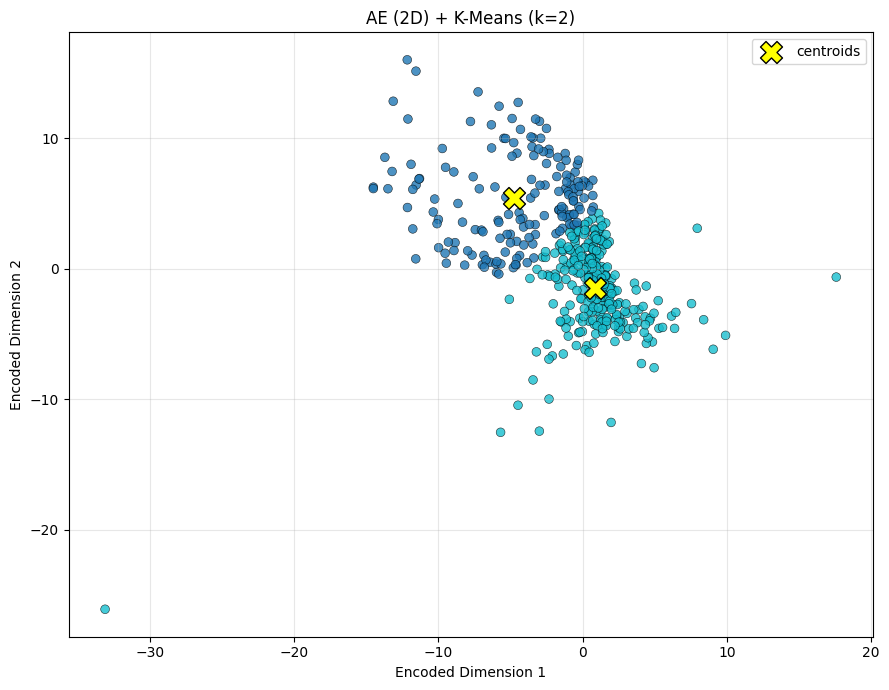

Cluster sizes (k=2):
  cluster 0: 163
  cluster 1: 304

Top 5 differentiators per cluster (z-score):

Cluster 0:
  ↑ ['2P:+0.97σ', '2PA:+0.93σ', 'TRB:+0.93σ', 'DRB:+0.91σ', 'FG:+0.89σ']
  ↓ ['STL%:-0.11σ', '3P%:-0.28σ', '3PAr:-0.65σ', 'Unnamed: 0:-0.66σ', 'Cluster_AE:-1.37σ']

Cluster 1:
  ↑ ['Cluster_AE:+0.73σ', 'Unnamed: 0:+0.35σ', '3PAr:+0.35σ', '3P%:+0.15σ', 'STL%:+0.06σ']
  ↓ ['FG:-0.48σ', 'DRB:-0.49σ', 'TRB:-0.50σ', '2PA:-0.50σ', '2P:-0.52σ']

Cluster 0 — top 5 by PTS:
            Player Name  PTS  Age   MP
            Joel Embiid 33.1   28 34.6
         Damian Lillard 32.2   32 36.3
Shai Gilgeous-Alexander 31.4   24 35.5
  Giannis Antetokounmpo 31.1   28 32.1
           Jayson Tatum 30.1   24 36.9

Cluster 1 — top 5 by PTS:
    Player Name  PTS  Age   MP
     Louis King 20.0   23 29.0
De'Andre Hunter 15.4   25 31.7
    Skylar Mays 15.3   25 31.5
  Collin Sexton 14.3   24 23.9
  Dillon Brooks 14.3   27 30.3


In [337]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# safety: ensure we have the 2-D embedding
assert 'X_encoded' in globals() and X_encoded.shape[1] == 2, "X_encoded (n×2) not found."

K_range = range(2, 11)
inertias, sils = [], []

for k in K_range:
    km = KMeans(n_clusters=k, n_init=25, random_state=42)
    lab = km.fit_predict(X_encoded)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X_encoded, lab))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(list(K_range), inertias, 'o-', lw=2)
ax[0].set_title("Elbow (Inertia)"); ax[0].set_xlabel("k"); ax[0].set_ylabel("Inertia"); ax[0].grid(True, alpha=.3)

ax[1].plot(list(K_range), sils, 'o-', lw=2)
ax[1].set_title("Silhouette score"); ax[1].set_xlabel("k"); ax[1].set_ylabel("Silhouette"); ax[1].grid(True, alpha=.3)
plt.tight_layout(); plt.show()

print("Silhouette by k:")
for k, s in zip(K_range, sils):
    print(f"  k={k}: {s:.3f}")

best_k = int(K_range[int(np.argmax(sils))])
print(f"\nAuto-selected k (max silhouette): {best_k}")

k = best_k   

kmeans = KMeans(n_clusters=k, n_init=25, random_state=42)
labels = kmeans.fit_predict(X_encoded)
centroids = kmeans.cluster_centers_

# scatter colored by cluster
plt.figure(figsize=(9, 7))
sc = plt.scatter(X_encoded[:, 0], X_encoded[:, 1],
                 c=labels, cmap='tab10', s=40, alpha=0.8,
                 edgecolors='k', linewidths=0.4)
plt.scatter(centroids[:, 0], centroids[:, 1],
            c='yellow', edgecolors='black', s=250, marker='X', label='centroids')
plt.xlabel("Encoded Dimension 1"); plt.ylabel("Encoded Dimension 2")
plt.title(f"AE (2D) + K-Means (k={k})")
plt.legend(loc='best'); plt.grid(True, alpha=.3)
plt.tight_layout(); plt.show()

# quick cluster stats
import pandas as pd
unique, counts = np.unique(labels, return_counts=True)
print(f"Cluster sizes (k={k}):")
for c, n in zip(unique, counts):
    print(f"  cluster {c}: {n}")

dfAE = dfCleaned.copy()
dfAE['Cluster_AE'] = labels

# shows top differentiators (z-scores) per cluster
num_cols = dfAE.select_dtypes(include=np.number).columns
global_mean, global_std = dfAE[num_cols].mean(), dfAE[num_cols].std(ddof=0)
z_by_cluster = (dfAE.groupby('Cluster_AE')[num_cols].mean() - global_mean) / global_std

print("\nTop 5 differentiators per cluster (z-score):")
for c in unique:
    z = z_by_cluster.loc[c].dropna().sort_values(ascending=False)
    up = [f"{feat}:+{val:.2f}σ" for feat, val in z.head(5).items()]
    dn = [f"{feat}:{val:.2f}σ"  for feat, val in z.tail(5).items()]
    print(f"\nCluster {c}:\n  ↑ {up}\n  ↓ {dn}")

# shows a few example players per cluster (if your df has names)
if 'Player Name' in dfAE.columns and 'PTS' in dfAE.columns:
    for c in unique:
        samp = (dfAE[dfAE['Cluster_AE'] == c]
                .nlargest(5, 'PTS')[['Player Name', 'PTS', 'Age', 'MP']])
        print(f"\nCluster {c} — top 5 by PTS:")
        print(samp.to_string(index=False))

Question 2.1 (b)

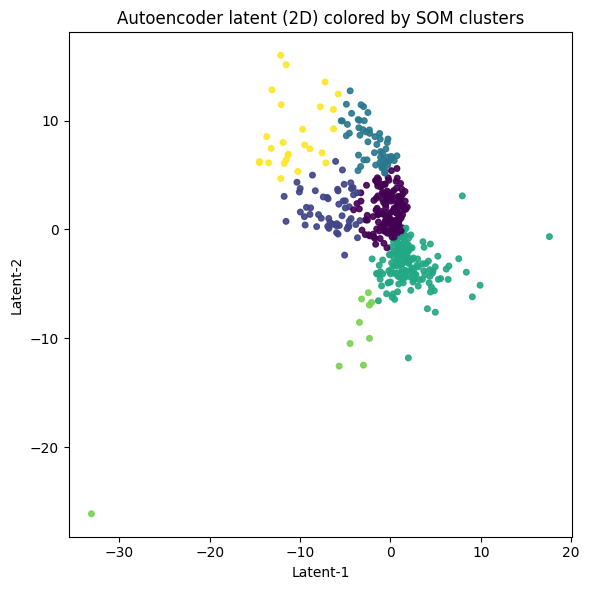

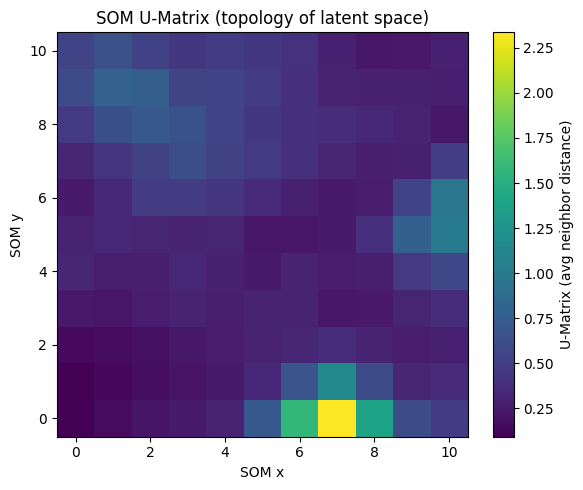

Cluster sizes: {np.int32(0): np.int64(162), np.int32(1): np.int64(54), np.int32(2): np.int64(54), np.int32(3): np.int64(161), np.int32(4): np.int64(10), np.int32(5): np.int64(26)}
         count      mean       std       min       25%       50%       75%  \
cluster                                                                      
0        162.0  0.253998  0.204943  0.075604  0.148343  0.204160  0.283120   
1         54.0  0.314319  0.256195  0.058740  0.174014  0.230672  0.376855   
2         54.0  0.327138  0.182433  0.088636  0.197338  0.275184  0.404160   
3        161.0  0.372114  0.409833  0.054295  0.167353  0.240929  0.391624   
4         10.0  0.739385  0.672779  0.165049  0.322570  0.516550  1.023397   
5         26.0  0.347823  0.218356  0.090229  0.204516  0.263612  0.465192   

              max  
cluster            
0        1.980679  
1        1.706241  
2        0.853326  
3        2.746945  
4        2.375743  
5        0.906656  


In [338]:
import numpy as np
import matplotlib.pyplot as plt
from minisom import MiniSom
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

Z = X_encoded.astype(np.float32)

# Scale latent for SOM
z_scaler = StandardScaler()
Zs = z_scaler.fit_transform(Z)

# SOM config
n_samples = Zs.shape[0]
tot_neurons = int(np.ceil(5*np.sqrt(n_samples)))
side = max(5, int(np.ceil(np.sqrt(tot_neurons))))
som_x, som_y = side, side

som = MiniSom(x=som_x, y=som_y, input_len=Zs.shape[1],
              sigma=1.5, learning_rate=0.5,
              neighborhood_function='gaussian', random_seed=42)

som.random_weights_init(Zs)
som.train_batch(Zs, num_iteration=2000, verbose=False)  # bump iterations if time allows

# Maps each sample to its BMU (best matching unit) on the grid
bmus = np.array([som.winner(z) for z in Zs])                  
bmu_ids = np.array([i*som_y + j for (i,j) in bmus])           

# SOM Codebook
codebook = som.get_weights().reshape(-1, Zs.shape[1])        

# K clusters
k = 6
kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
neuron_labels = kmeans.fit_predict(codebook)                   

# Assign each sample the cluster of its BMU
cluster_labels = neuron_labels[bmu_ids]

plt.figure(figsize=(6,6))
plt.scatter(Z[:,0], Z[:,1], c=cluster_labels, s=16, alpha=0.9)
plt.xlabel('Latent-1'); plt.ylabel('Latent-2')
plt.title('Autoencoder latent (2D) colored by SOM clusters')
plt.tight_layout()
plt.show()


# Build U-Matrix
umatrix = np.zeros((som_x, som_y))
W = som.get_weights() 
for i in range(som_x):
    for j in range(som_y):
        neighbors = []
        for di, dj in [(1,0),(-1,0),(0,1),(0,-1)]:
            ii, jj = i+di, j+dj
            if 0 <= ii < som_x and 0 <= jj < som_y:
                neighbors.append(np.linalg.norm(W[i,j] - W[ii,jj]))
        umatrix[i,j] = np.mean(neighbors) if neighbors else 0.0

plt.figure(figsize=(6,5))
plt.imshow(umatrix.T, origin='lower', cmap='viridis', aspect='auto')
plt.colorbar(label='U-Matrix (avg neighbor distance)')
plt.title('SOM U-Matrix (topology of latent space)')
plt.xlabel('SOM x'); plt.ylabel('SOM y')
plt.tight_layout()
plt.show()

# Quick cluster sizes and a peek at reconstruction error per cluster
unique, counts = np.unique(cluster_labels, return_counts=True)
print("Cluster sizes:", dict(zip(unique, counts)))

if 'reconstruction_errors' in globals():
    import pandas as pd
    tmp = pd.DataFrame({'cluster': cluster_labels, 'recon_err': reconstruction_errors})
    print(tmp.groupby('cluster')['recon_err'].describe())

In [339]:
import pandas as pd
Z = X_encoded  # latent
dfX = pd.DataFrame(xScaled, columns=dfCleaned.drop(columns=["Player Name","Team","Position"], errors="ignore").columns)
g = pd.DataFrame({'cluster': cluster_labels})
summary = dfX.join(g).groupby('cluster').mean()
# Compare cluster means to global mean
delta = summary - dfX.mean()
print(delta.sort_index())

         Unnamed: 0    Salary       Age        GP        GS        MP  \
cluster                                                                 
0         -0.223724 -0.026345  0.075365  0.528624  0.178931  0.392724   
1          0.080497 -0.204474 -0.135671  0.222239 -0.243683 -0.285104   
2         -1.147835  1.412497  0.185219  0.654168  1.465474  1.511328   
3          0.687828 -0.541761 -0.098960 -0.827261 -0.763916 -0.889619   
4          1.294405 -0.713247 -0.285709 -1.760749 -0.836893 -1.518202   
5         -1.146334  1.284257  0.150194  0.685899  1.399842  1.098977   

               FG       FGA       FG%        3P  ...      TOV%      USG%  \
cluster                                          ...                       
0        0.096954  0.151150 -0.074323  0.421928  ... -0.151452 -0.137399   
1       -0.234172 -0.434655  1.007369 -0.800243  ...  0.306608 -0.341934   
2        1.869601  1.994974 -0.024207  1.571445  ... -0.125012  1.501386   
3       -0.806299 -0.753853 -0.5213

Question 2.2 (b)

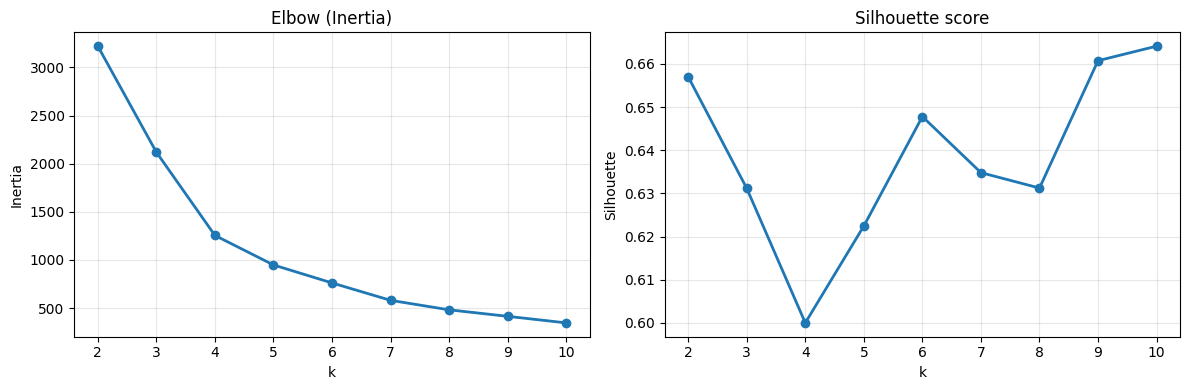

Silhouette by k:
  k=2: 0.657
  k=3: 0.631
  k=4: 0.600
  k=5: 0.622
  k=6: 0.648
  k=7: 0.635
  k=8: 0.631
  k=9: 0.661
  k=10: 0.664

Auto-selected k (max silhouette): 10


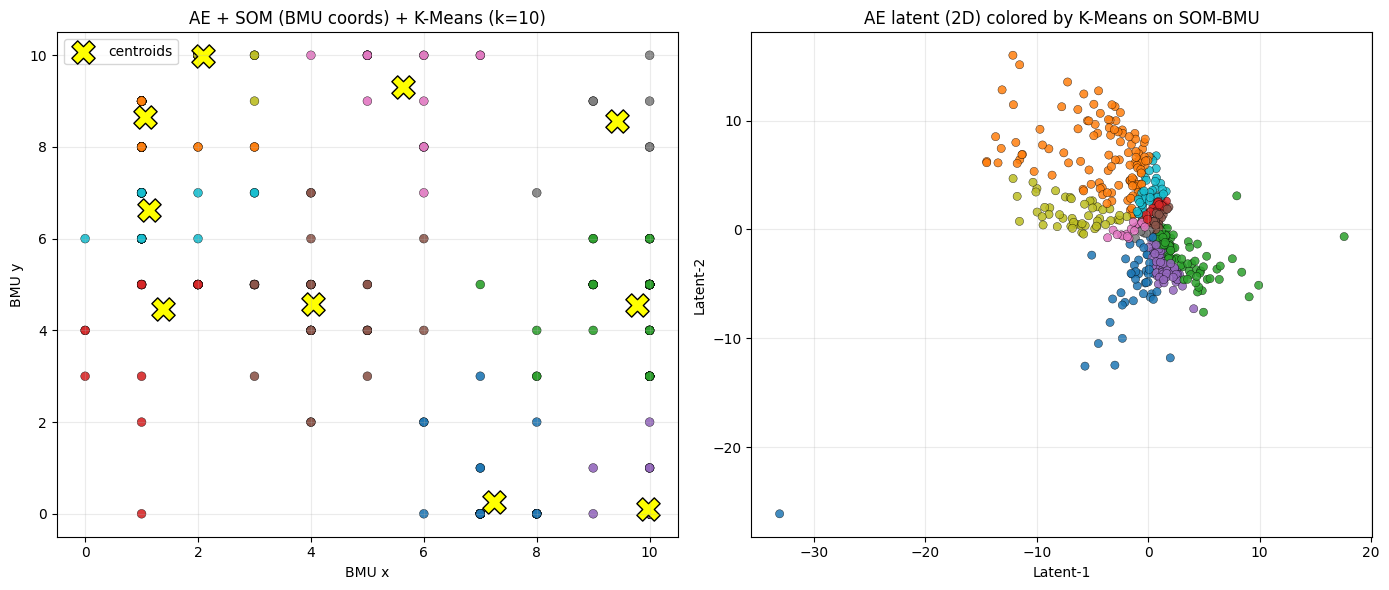

Cluster sizes (k=10):
  cluster 0: 44
  cluster 1: 110
  cluster 2: 81
  cluster 3: 26
  cluster 4: 60
  cluster 5: 36
  cluster 6: 16
  cluster 7: 7
  cluster 8: 48
  cluster 9: 39

Top 5 differentiators per cluster (z-score):

Cluster 0:
  ↑ ['TS%:+0.95σ', 'eFG%:+0.89σ', '3P%:+0.79σ', 'FG%:+0.74σ', '2P%:+0.74σ']
  ↓ ['FGA:-0.84σ', 'DWS:-0.85σ', 'Total Minutes:-1.02σ', 'MP:-1.04σ', 'GP:-1.05σ']

Cluster 1:
  ↑ ['2P:+1.39σ', '2PA:+1.38σ', 'FG:+1.36σ', 'PTS:+1.34σ', 'DRB:+1.29σ']
  ↓ ['3P%:+0.01σ', 'TOV%:-0.03σ', 'STL%:-0.10σ', '3PAr:-0.46σ', 'Unnamed: 0:-1.00σ']

Cluster 2:
  ↑ ['Unnamed: 0:+0.61σ', '3PAr:+0.51σ', 'TOV%:+0.13σ', 'STL%:-0.11σ', 'ORB%:-0.16σ']
  ↓ ['PER:-1.11σ', 'FG%:-1.16σ', 'eFG%:-1.18σ', 'WS/48:-1.20σ', 'TS%:-1.29σ']

Cluster 3:
  ↑ ['GP:+0.89σ', 'Total Minutes:+0.83σ', '3P:+0.70σ', '3PA:+0.69σ', 'DWS:+0.61σ']
  ↓ ['BLK%:-0.31σ', 'FTr:-0.45σ', 'DRB%:-0.50σ', 'ORB%:-0.54σ', 'TRB%:-0.59σ']

Cluster 4:
  ↑ ['Unnamed: 0:+0.68σ', '3PAr:+0.21σ', 'Age:+0.14σ', '3P%:+0.14σ', 

In [340]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd

# Maps each point to its SOM Best Matching Unit (BMU) coordinate (i, j)
bmu_list = [som.winner(x) for x in X_encoded]           # list of (i, j)
bmu_xy   = np.array([[i, j] for (i, j) in bmu_list], dtype=float)  # shape: (n, 2)
name     = "AE + SOM (BMU coords)"

# elbow and sil
K_range = range(2, 11)
inertias, sils = [], []
for k in K_range:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    lab = km.fit_predict(bmu_xy)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(bmu_xy, lab))

# Plot of elbow & silhouette
fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].plot(list(K_range), inertias, "o-", lw=2); axes[0].set_title("Elbow (Inertia)")
axes[0].set_xlabel("k"); axes[0].set_ylabel("Inertia"); axes[0].grid(True, alpha=.3)

axes[1].plot(list(K_range), sils, "o-", lw=2); axes[1].set_title("Silhouette score")
axes[1].set_xlabel("k"); axes[1].set_ylabel("Silhouette"); axes[1].grid(True, alpha=.3)
plt.tight_layout(); plt.show()

print("Silhouette by k:")
for k, s in zip(K_range, sils):
    print(f"  k={k}: {s:.3f}")

# max k for sil
k_star = int(K_range[int(np.argmax(sils))])
print(f"\nAuto-selected k (max silhouette): {k_star}")

# k means
kmeans_bmu = KMeans(n_clusters=k_star, n_init=20, random_state=42)
labels_km_bmu = kmeans_bmu.fit_predict(bmu_xy)

fig, axes = plt.subplots(1, 2, figsize=(14,6))

# BMU grid scatter
sc0 = axes[0].scatter(bmu_xy[:,0], bmu_xy[:,1], c=labels_km_bmu, cmap="tab10",
                      s=40, alpha=0.9, edgecolors="k", linewidths=0.3)
cent = kmeans_bmu.cluster_centers_
axes[0].scatter(cent[:,0], cent[:,1], c="yellow", edgecolors="black", s=280, marker="X", label="centroids")
axes[0].set_title(f"{name} + K-Means (k={k_star})")
axes[0].set_xlabel("BMU x"); axes[0].set_ylabel("BMU y")
axes[0].grid(True, alpha=.25); axes[0].legend()

# Original AE latent colored by the same labels
sc1 = axes[1].scatter(X_encoded[:,0], X_encoded[:,1], c=labels_km_bmu, cmap="tab10",
                      s=35, alpha=0.85, edgecolors="k", linewidths=0.3)
axes[1].set_title("AE latent (2D) colored by K-Means on SOM-BMU")
axes[1].set_xlabel("Latent-1"); axes[1].set_ylabel("Latent-2")
axes[1].grid(True, alpha=.25)

plt.tight_layout(); plt.show()

unique, counts = np.unique(labels_km_bmu, return_counts=True)
print(f"Cluster sizes (k={k_star}):")
for u, c in zip(unique, counts):
    print(f"  cluster {u}: {c}")

numeric_cols = dfCleaned.select_dtypes(include=[np.number]).columns
df_tmp = dfCleaned.copy()
df_tmp["Cluster_AE_SOM_KM"] = labels_km_bmu

glob_mean, glob_std = df_tmp[numeric_cols].mean(), df_tmp[numeric_cols].std()
cluster_mean = df_tmp.groupby("Cluster_AE_SOM_KM")[numeric_cols].mean()
z = (cluster_mean - glob_mean) / glob_std

print("\nTop 5 differentiators per cluster (z-score):")
for cid in sorted(unique):
    zc = z.loc[cid].sort_values(ascending=False)
    ups = [f"{k}:{v:+.2f}σ" for k, v in zc.head(5).items()]
    downs = [f"{k}:{v:+.2f}σ" for k, v in zc.tail(5).items()]
    print(f"\nCluster {cid}:\n  ↑ {ups}\n  ↓ {downs}")

Question 2.1 (c)

In [341]:
from sklearn.manifold import TSNE
import os, random, numpy as np
import tensorflow as tf

# Make results reproducible
os.environ["PYTHONHASHSEED"] = "42"
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

inputDimension = xTrain.shape[1]
latentDimension = 16  # Higher than final 2D - gives t-SNE more to work with

# Regularization coefficients
lambda1 = 1e-5
lambda2 = 1e-4

# Encoder: reduces to latentDimension
encoder_tsne = models.Sequential([
    layers.Input(shape=(inputDimension,)),
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(lambda1)),
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(lambda2)),
    layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(lambda2)),
    layers.Dense(latentDimension, activation='linear')
], name='encoder_tsne')

# Decoder: reconstructs from latentDimension
decoder_tsne = models.Sequential([
    layers.Input(shape=(latentDimension,)),
    layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(lambda2)),
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(lambda2)),
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(lambda1)),
    layers.Dense(inputDimension, activation='linear')
], name='decoder_tsne')

# Full autoencoder
autoencoder_tsne = models.Sequential([encoder_tsne, decoder_tsne], name='ae_tsne')
autoencoder_tsne.compile(optimizer='adam', loss='mse')

print(f"Encoder output shape: {latentDimension}D")
print(f"Input dimension: {inputDimension}D")

# %%
# Train the autoencoder
history_tsne = autoencoder_tsne.fit(
    xTrain, xTrain,
    epochs=100,
    batch_size=32,
    validation_data=(xTest, xTest),
    verbose=1
)

Encoder output shape: 16D
Input dimension: 49D
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.9889 - val_loss: 1.0227
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8859 - val_loss: 0.7680
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6602 - val_loss: 0.5999
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5405 - val_loss: 0.4837
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4647 - val_loss: 0.4149
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4103 - val_loss: 0.3863
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3700 - val_loss: 0.3660
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3379 - val_loss: 0.3446
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3122 - val_loss: 0.3371
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2936 - val_loss: 0.3272
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2780 - val_loss: 0.3214
Epoch 12/100
12

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Latent representation shape: (467, 16)
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


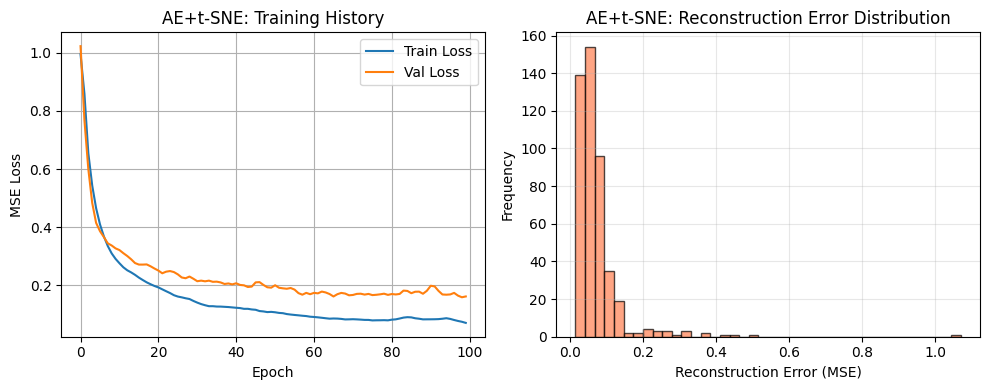

Mean reconstruction error: 0.0728
Std reconstruction error: 0.0743


In [342]:
# Plot training history
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_tsne.history['loss'], label='Train Loss')
plt.plot(history_tsne.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('AE+t-SNE: Training History')
plt.legend()
plt.grid(True)

# Extract latent representations
X_latent = encoder_tsne.predict(xScaled)
print(f"\nLatent representation shape: {X_latent.shape}")

# Calculate reconstruction error
X_reconstructed_tsne = autoencoder_tsne.predict(xScaled)
reconstruction_errors_tsne = np.mean(np.square(xScaled - X_reconstructed_tsne), axis=1)

plt.subplot(1, 2, 2)
plt.hist(reconstruction_errors_tsne, bins=40, color='coral', edgecolor='k', alpha=0.7)
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Frequency')
plt.title('AE+t-SNE: Reconstruction Error Distribution')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Mean reconstruction error: {np.mean(reconstruction_errors_tsne):.4f}")
print(f"Std reconstruction error: {np.std(reconstruction_errors_tsne):.4f}")


t-SNE embedding shape: (467, 2)
KL divergence (final): 0.8698


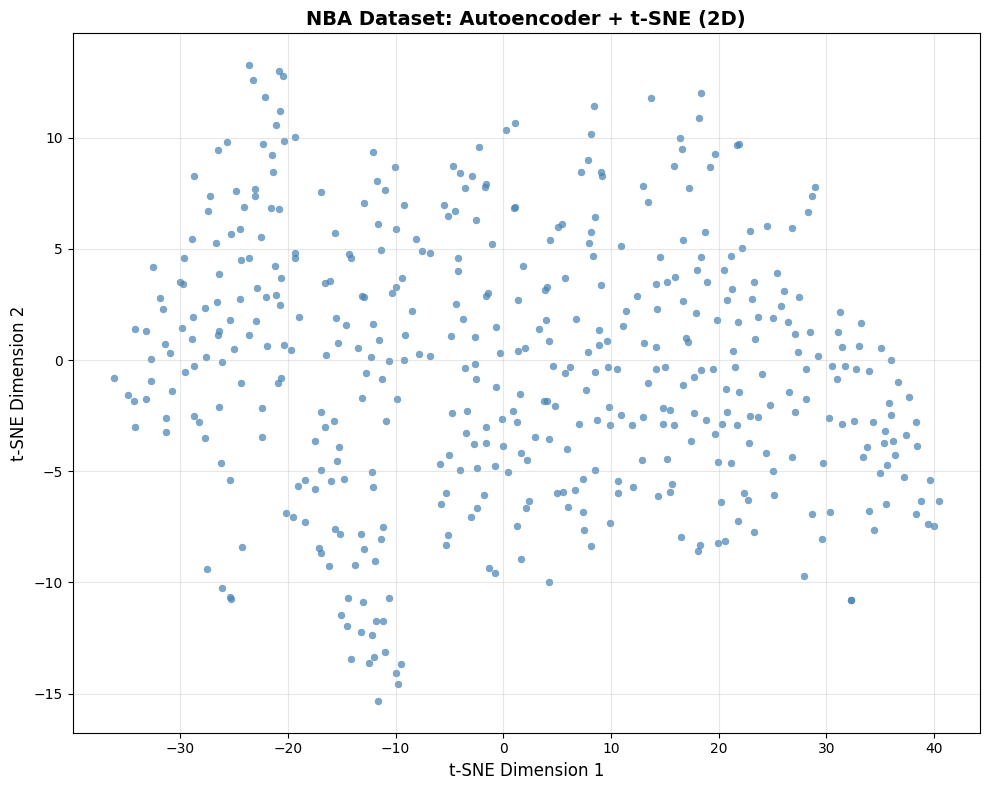

In [343]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
warnings.filterwarnings("ignore", category=RuntimeWarning, module="sklearn")

tsne = TSNE(
    n_components=2,
    perplexity=30,
    early_exaggeration=12,
    learning_rate='auto',
    init ='pca',
    n_iter=1500,
    random_state=42,
    verbose=0
)

X_tsne = tsne.fit_transform(X_latent)
print(f"t-SNE embedding shape: {X_tsne.shape}")
try:
    print(f"KL divergence (final): {tsne.kl_divergence_:.4f}")
except AttributeError:
    pass

# %%
# Visualize the t-SNE embedding

plt.figure(figsize=(10, 8))
plt.scatter(
    X_tsne[:, 0], X_tsne[:, 1],
    s=25, alpha=0.7, c='steelblue',
    marker='o', linewidth=0.3
)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.title('NBA Dataset: Autoencoder + t-SNE (2D)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Question 2.2(c)

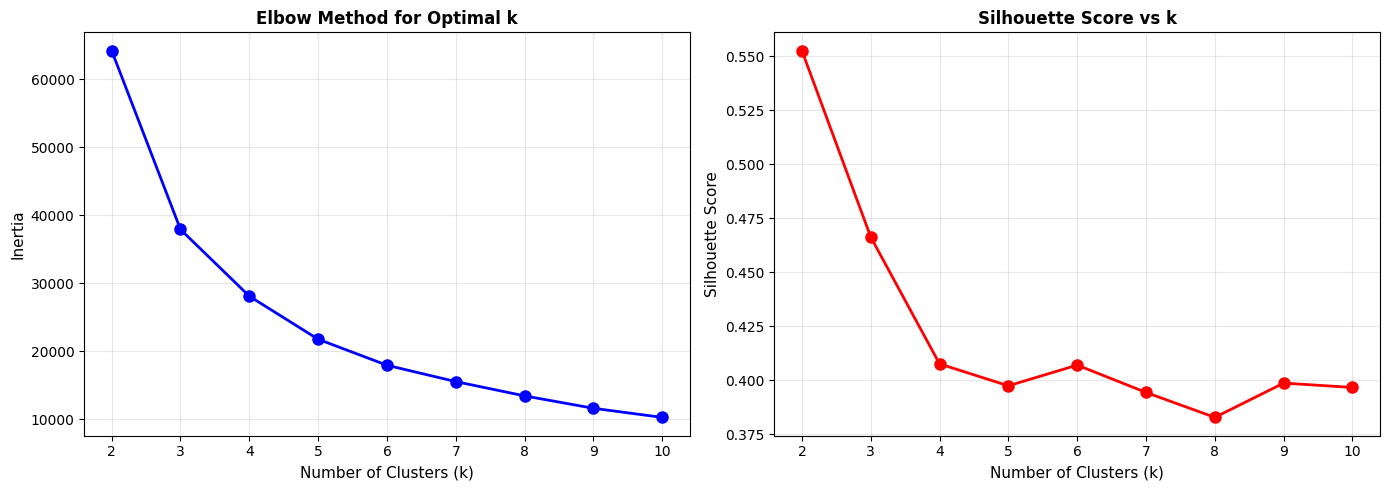

Silhouette scores by k:
  k=2: 0.5525
  k=3: 0.4663
  k=4: 0.4076
  k=5: 0.3975
  k=6: 0.4070
  k=7: 0.3944
  k=8: 0.3829
  k=9: 0.3987
  k=10: 0.3967

Cluster sizes (k=6):
  Cluster 0: 92 players
  Cluster 1: 95 players
  Cluster 2: 63 players
  Cluster 3: 56 players
  Cluster 4: 69 players
  Cluster 5: 92 players


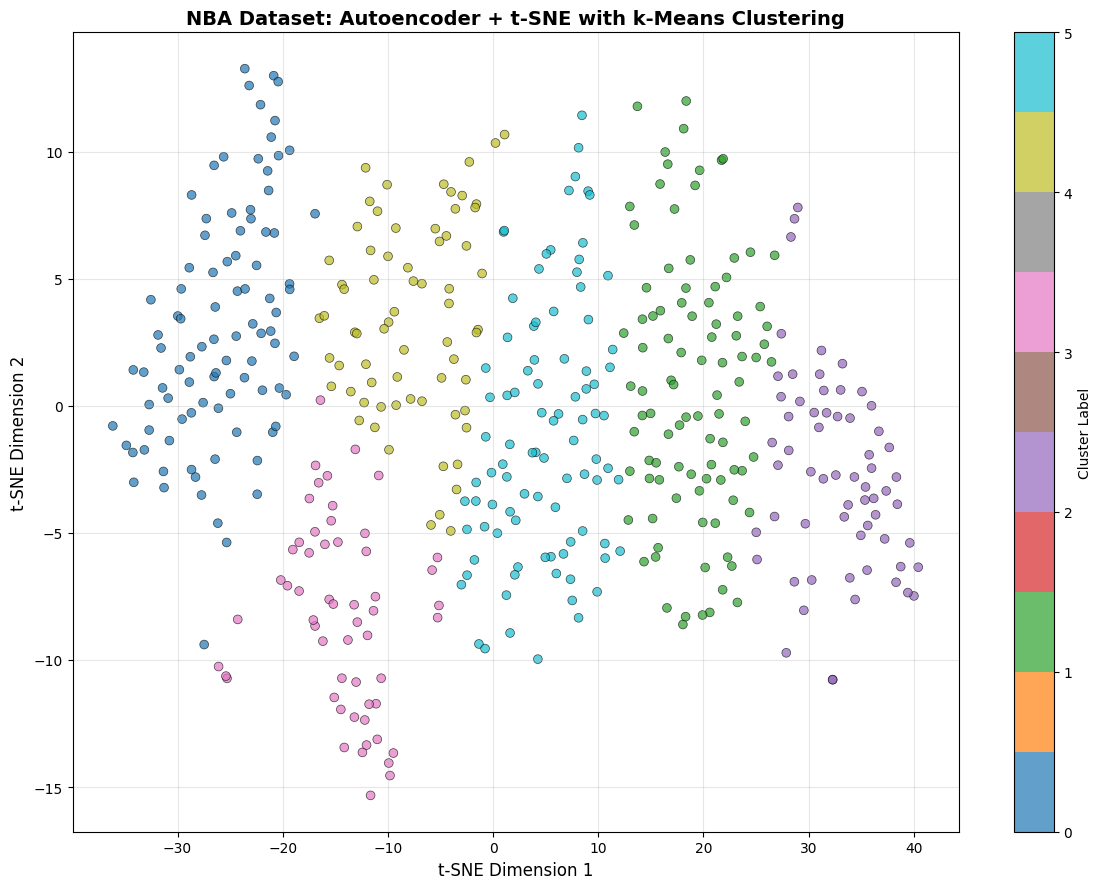


CLUSTER CHARACTERIZATION (Top 5 differentiating features by z-score)

--- Cluster 0 (n=92) ---
  Highest features (above average):
    Unnamed: 0  : +1.13σ
    3PAr        : +0.30σ
    STL%        : +0.24σ
    TOV%        : +0.10σ
    BLK%        : -0.04σ
  Lowest features (below average):
    DWS         : -1.02σ
    Total Minutes: -1.19σ
    PF          : -1.19σ
    MP          : -1.21σ
    GP          : -1.35σ

--- Cluster 1 (n=95) ---
  Highest features (above average):
    Total Minutes: +0.96σ
    GP          : +0.84σ
    GS          : +0.81σ
    MP          : +0.80σ
    DWS         : +0.70σ
  Lowest features (below average):
    BLK%        : -0.26σ
    DRB%        : -0.34σ
    TRB%        : -0.45σ
    ORB%        : -0.47σ
    Unnamed: 0  : -0.58σ

--- Cluster 2 (n=63) ---
  Highest features (above average):
    PTS         : +1.94σ
    FGA         : +1.92σ
    FG          : +1.89σ
    FT          : +1.78σ
    TOV         : +1.78σ
  Lowest features (below average):
    3PAr    

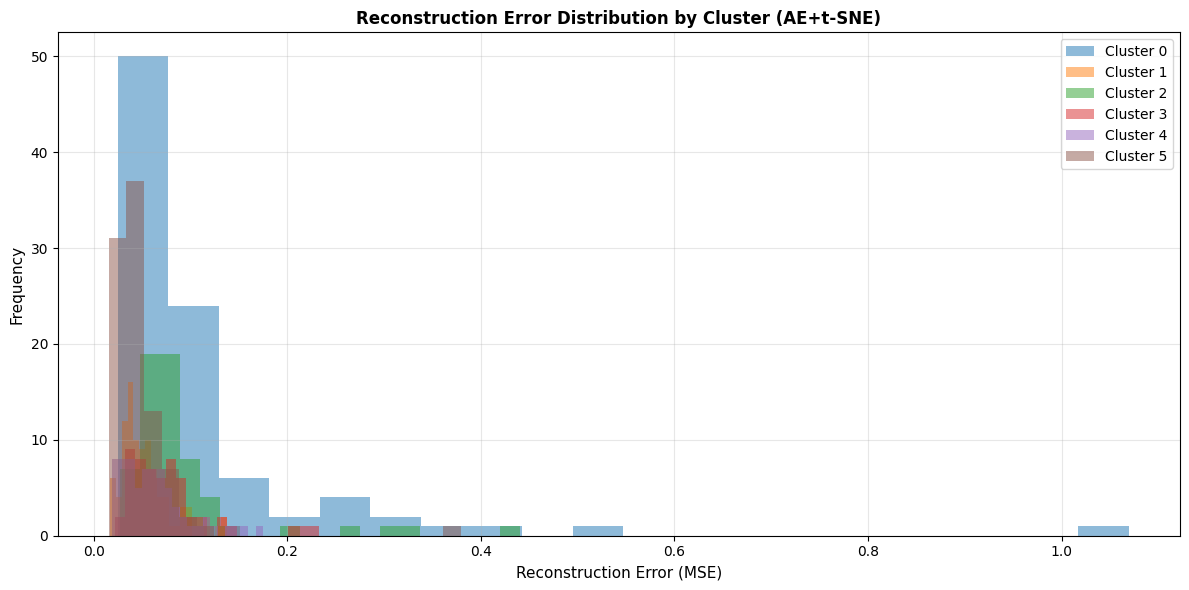


✓ Autoencoder + t-SNE analysis complete!


In [344]:
import warnings, numpy as np

# Silence sklearn’s noisy linear-algebra warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, module="sklearn.utils.extmath")
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

inertias = []
silhouette_scores = []
K_range = range(2, 11)

from sklearn.metrics import silhouette_score

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels_temp = kmeans_temp.fit_predict(X_tsne)
    inertias.append(kmeans_temp.inertia_)
    silhouette_scores.append(silhouette_score(X_tsne, labels_temp))

# Plot elbow curve and silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[0].set_ylabel('Inertia', fontsize=11)
axes[0].set_title('Elbow Method for Optimal k', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[1].set_ylabel('Silhouette Score', fontsize=11)
axes[1].set_title('Silhouette Score vs k', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Silhouette scores by k:")
for k, score in zip(K_range, silhouette_scores):
    print(f"  k={k}: {score:.4f}")

# Apply k-Means with chosen k
k = 6  # Adjust based on elbow/silhouette analysis
kmeans_tsne = KMeans(n_clusters=k, n_init=20, random_state=42)
labels_tsne = kmeans_tsne.fit_predict(X_tsne)

# Cluster statistics
unique_labels, counts = np.unique(labels_tsne, return_counts=True)
print(f"\nCluster sizes (k={k}):")
for label, count in zip(unique_labels, counts):
    print(f"  Cluster {label}: {count} players")

# Visualize clustered t-SNE embedding
plt.figure(figsize=(12, 9))
scatter = plt.scatter(
    X_tsne[:, 0], X_tsne[:, 1],
    c=labels_tsne,
    cmap='tab10',
    s=40,
    alpha=0.7,
    edgecolors='k',
    linewidth=0.5
)
plt.colorbar(scatter, label='Cluster Label', ticks=range(k))
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.title('NBA Dataset: Autoencoder + t-SNE with k-Means Clustering', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Add cluster labels to the dataframe
dfAnalysis = dfCleaned.copy()
dfAnalysis['Cluster_AE_tSNE'] = labels_tsne

# Statistical summary by cluster
numeric_cols = dfCleaned.select_dtypes(include=[np.number]).columns
cluster_summary = dfAnalysis.groupby('Cluster_AE_tSNE')[numeric_cols].mean()

# Calculate z-scores relative to global mean
global_mean = dfAnalysis[numeric_cols].mean()
global_std = dfAnalysis[numeric_cols].std()
cluster_zscore = (cluster_summary - global_mean) / global_std

# Display top differentiating features per cluster
print("\n" + "="*80)
print("CLUSTER CHARACTERIZATION (Top 5 differentiating features by z-score)")
print("="*80)

for cluster_id in range(k):
    print(f"\n--- Cluster {cluster_id} (n={counts[cluster_id]}) ---")
    z = cluster_zscore.loc[cluster_id].sort_values(ascending=False)
    
    print("  Highest features (above average):")
    for feat, val in z.head(5).items():
        print(f"    {feat:12s}: {val:+.2f}σ")
    
    print("  Lowest features (below average):")
    for feat, val in z.tail(5).items():
        print(f"    {feat:12s}: {val:+.2f}σ")

# Show example players from each cluster
print("\n" + "="*80)
print("EXAMPLE PLAYERS PER CLUSTER")
print("="*80)

for cluster_id in range(k):
    cluster_players = dfAnalysis[dfAnalysis['Cluster_AE_tSNE'] == cluster_id]
    
    # Sample random players or top by a metric
    if 'Player Name' in dfCleaned.columns and 'PTS' in dfCleaned.columns:
        sample = cluster_players.nlargest(5, 'PTS')[['Player Name', 'PTS', 'Age', 'MP']]
        print(f"\nCluster {cluster_id} - Top 5 by PTS:")
        print(sample.to_string(index=False))

# Reconstruction error by cluster
recon_by_cluster = pd.DataFrame({
    'Cluster': labels_tsne,
    'Reconstruction_Error': reconstruction_errors_tsne
})

print("\n" + "="*80)
print("RECONSTRUCTION ERROR BY CLUSTER")
print("="*80)
print(recon_by_cluster.groupby('Cluster')['Reconstruction_Error'].describe())

# Visualize reconstruction error distribution by cluster
plt.figure(figsize=(12, 6))
for cluster_id in range(k):
    cluster_errors = recon_by_cluster[recon_by_cluster['Cluster'] == cluster_id]['Reconstruction_Error']
    plt.hist(cluster_errors, bins=20, alpha=0.5, label=f'Cluster {cluster_id}')

plt.xlabel('Reconstruction Error (MSE)', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Reconstruction Error Distribution by Cluster (AE+t-SNE)', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ Autoencoder + t-SNE analysis complete!")

Question 2.1 (d)

UMAP(n_epochs=500, n_jobs=1, random_state=42, verbose=True)
Sat Oct 25 13:37:38 2025 Construct fuzzy simplicial set
Sat Oct 25 13:37:38 2025 Finding Nearest Neighbors
Sat Oct 25 13:37:38 2025 Finished Nearest Neighbor Search
Sat Oct 25 13:37:38 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs


Epochs completed:  31%| ███▏       157/500 [00:00]

	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs


Epochs completed:  63%| ██████▎    314/500 [00:00]

	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs


Epochs completed:  96%| █████████▋ 482/500 [00:00]

	completed  450  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:00]

Sat Oct 25 13:37:39 2025 Finished embedding
UMAP embedding shape: (467, 2)


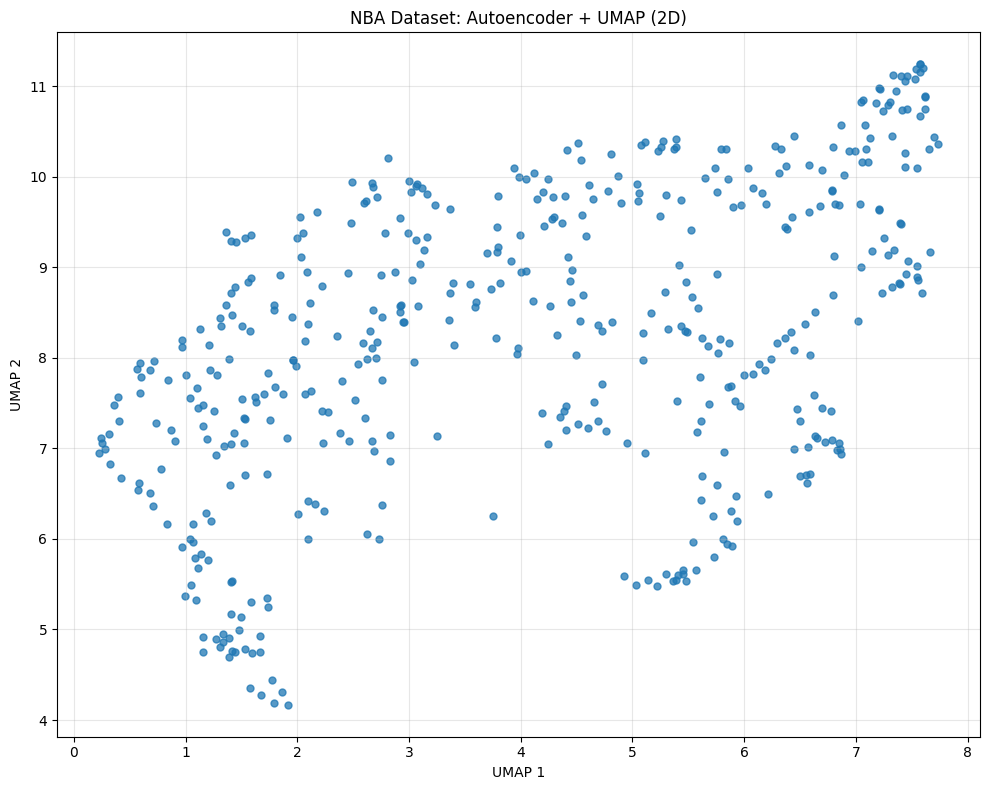

In [345]:
# ===== AE + UMAP =====
import warnings, numpy as np, matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=RuntimeWarning, module="sklearn.utils.extmath")
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
warnings.filterwarnings("ignore", category=UserWarning, module="umap")

# latent rep for UMAP
try:
    X_latent  # check it exists
except NameError:
    from tensorflow.keras import layers, models, regularizers
    inputDimension = xTrain.shape[1]
    latentDimension = 16
    lambda1, lambda2 = 1e-5, 1e-4

    encoder_umap = models.Sequential([
        layers.Input(shape=(inputDimension,)),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(lambda1)),
        layers.Dense(64,  activation='relu', kernel_regularizer=regularizers.l2(lambda2)),
        layers.Dense(32,  activation='relu', kernel_regularizer=regularizers.l2(lambda2)),
        layers.Dense(latentDimension, activation='linear')
    ])
    decoder_umap = models.Sequential([
        layers.Input(shape=(latentDimension,)),
        layers.Dense(32,  activation='relu', kernel_regularizer=regularizers.l2(lambda2)),
        layers.Dense(64,  activation='relu', kernel_regularizer=regularizers.l2(lambda2)),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(lambda1)),
        layers.Dense(inputDimension, activation='linear')
    ])
    ae_umap = models.Sequential([encoder_umap, decoder_umap])
    ae_umap.compile(optimizer='adam', loss='mse')
    _ = ae_umap.fit(xTrain, xTrain, epochs=60, batch_size=32, validation_data=(xTest, xTest), verbose=0)
    X_latent = encoder_umap.predict(xScaled)

# UMAP
import umap
np.random.seed(42)
umap_model = umap.UMAP(
    n_neighbors=15,     
    min_dist=0.1,       
    n_components=2,
    metric='euclidean',
    n_epochs=500,
    random_state=42,
    verbose=True
)

# Guard against NaNs sneaking in
assert np.isfinite(X_latent).all(), "Non-finite values in latent space; check cleaning/imputation."
X_umap = umap_model.fit_transform(X_latent)
print("UMAP embedding shape:", X_umap.shape)

# Graph of 2D embedding
plt.figure(figsize=(10, 8))
plt.scatter(X_umap[:,0], X_umap[:,1], s=25, alpha=0.75)
plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2')
plt.title('NBA Dataset: Autoencoder + UMAP (2D)')
plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

Question 2.2 (d)

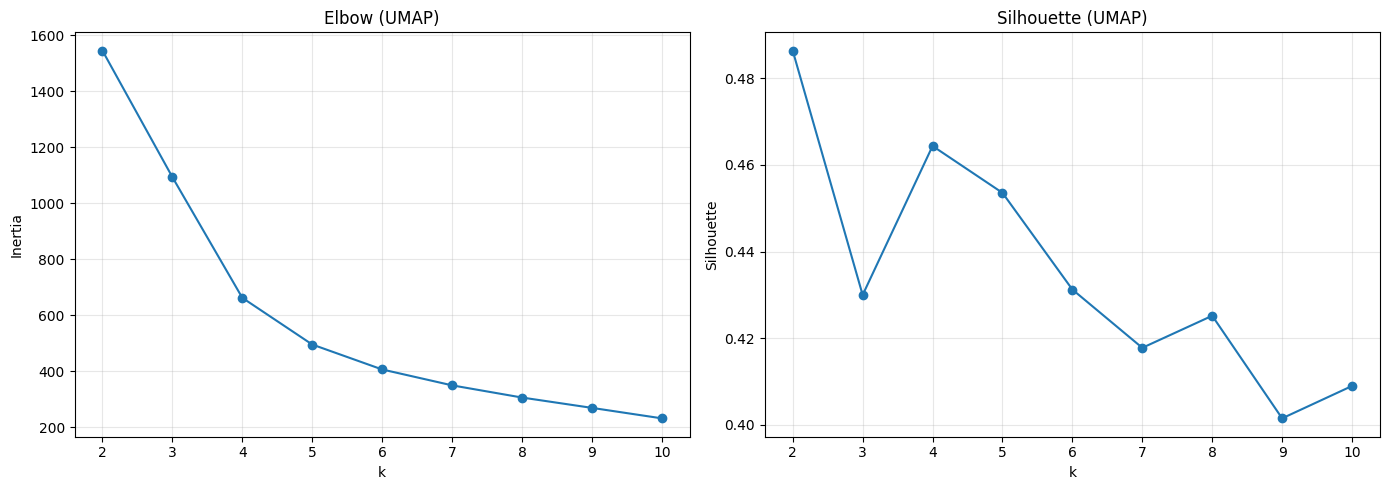

Silhouette by k: {2: np.float32(0.4864), 3: np.float32(0.43), 4: np.float32(0.4644), 5: np.float32(0.4536), 6: np.float32(0.4312), 7: np.float32(0.4178), 8: np.float32(0.4252), 9: np.float32(0.4015), 10: np.float32(0.4089)}
Chosen k: 2


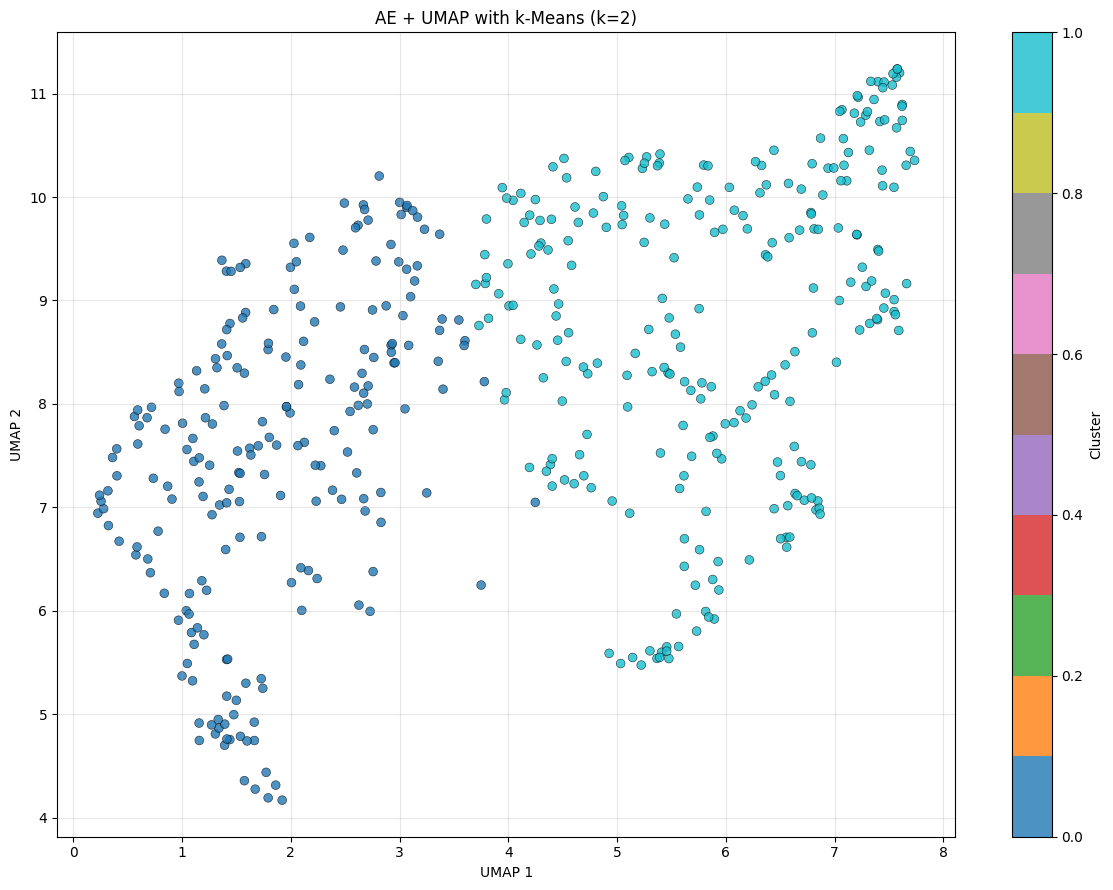


Top differentiators per cluster (z-score):

Cluster 0:
  ↑ ['Total Minutes:+0.79σ', 'MP:+0.78σ', '3PA:+0.78σ', '3P:+0.76σ', 'FGA:+0.74σ']
  ↓ ['Cluster_AE_UMAP:-1.10σ', 'Unnamed: 0:-0.66σ', 'ORB%:-0.45σ', 'TRB%:-0.37σ', 'DRB%:-0.24σ']

Cluster 1:
  ↑ ['Cluster_AE_UMAP:+0.91σ', 'Unnamed: 0:+0.55σ', 'ORB%:+0.37σ', 'TRB%:+0.30σ', 'DRB%:+0.20σ']
  ↓ ['Total Minutes:-0.65σ', 'MP:-0.65σ', '3PA:-0.64σ', '3P:-0.63σ', 'FGA:-0.61σ']


In [346]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

K_range = range(2, 11)
inertias, silhouettes = [], []

for k in K_range:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels_k = km.fit_predict(X_umap)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_umap, labels_k))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(K_range, inertias, 'o-'); axes[0].set_title('Elbow (UMAP)')
axes[0].set_xlabel('k'); axes[0].set_ylabel('Inertia'); axes[0].grid(True, alpha=.3)
axes[1].plot(K_range, silhouettes, 'o-'); axes[1].set_title('Silhouette (UMAP)')
axes[1].set_xlabel('k'); axes[1].set_ylabel('Silhouette'); axes[1].grid(True, alpha=.3)
plt.tight_layout(); plt.show()

best_k = K_range[int(np.argmax(silhouettes)) - 0]  # pick the argmax
print("Silhouette by k:", dict(zip(K_range, [round(s,4) for s in silhouettes])))
print("Chosen k:", best_k)

# fit final k-means and plot clusters
km = KMeans(n_clusters=best_k, n_init=20, random_state=42)
labels_umap = km.fit_predict(X_umap)

plt.figure(figsize=(12, 9))
sc = plt.scatter(X_umap[:,0], X_umap[:,1], c=labels_umap, cmap='tab10',
                 s=40, alpha=0.8, edgecolors='k', linewidth=.4)
plt.colorbar(sc, label='Cluster')
plt.title(f'AE + UMAP with k-Means (k={best_k})')
plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2'); plt.grid(True, alpha=.3)
plt.tight_layout(); plt.show()

# cluster characterization
dfAnalysis = dfCleaned.copy()
dfAnalysis['Cluster_AE_UMAP'] = labels_umap
numeric_cols = dfAnalysis.select_dtypes(np.number).columns
summary = dfAnalysis.groupby('Cluster_AE_UMAP')[numeric_cols].mean()

global_mean = dfAnalysis[numeric_cols].mean()
global_std  = dfAnalysis[numeric_cols].std()
z = (summary - global_mean) / global_std

print("\nTop differentiators per cluster (z-score):")
for cid in range(best_k):
    top5 = z.loc[cid].sort_values(ascending=False).head(5)
    bot5 = z.loc[cid].sort_values().head(5)
    print(f"\nCluster {cid}:")
    print("  ↑", [f"{k}:{v:+.2f}σ" for k,v in top5.items()])
    print("  ↓", [f"{k}:{v:+.2f}σ" for k,v in bot5.items()])

Question 2.1 (e) and 2.2(e)

Encoder architecture:


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 49)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_216 (Dense)   │ (None, 128)       │      6,400 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_217 (Dense)   │ (None, 64)        │      8,256 │ dense_216[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_218 (Dense)   │ (None, 32)        │      2,080 │ dense_217[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         66 │ dense_218[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         66 │ dense_218[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_6          │ (None, 2)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,868 (65.89 KB)

 Trainable params: 16,868 (65.89 KB)

 Non-trainable params: 0 (0.00 B)


Decoder architecture:


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ latent_input (InputLayer)       │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_219 (Dense)               │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_220 (Dense)               │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_221 (Dense)               │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_222 (Dense)               │ (None, 49)             │         6,321 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,849 (65.82 KB)

 Trainable params: 16,849 (65.82 KB)

 Non-trainable params: 0 (0.00 B)


VAE model created successfully!
Epoch 1/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - kl_loss: 0.1054 - reconstruction_loss: 47.7577 - total_loss: 47.8631 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 0.2974 - reconstruction_loss: 46.6452 - total_loss: 46.9426 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 2.0320 - reconstruction_loss: 41.0380 - total_loss: 43.0700 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 3.6759 - reconstruction_loss: 32.8663 - total_loss: 36.5422 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 2.5164 - reconstruction_loss: 30.3248 - total

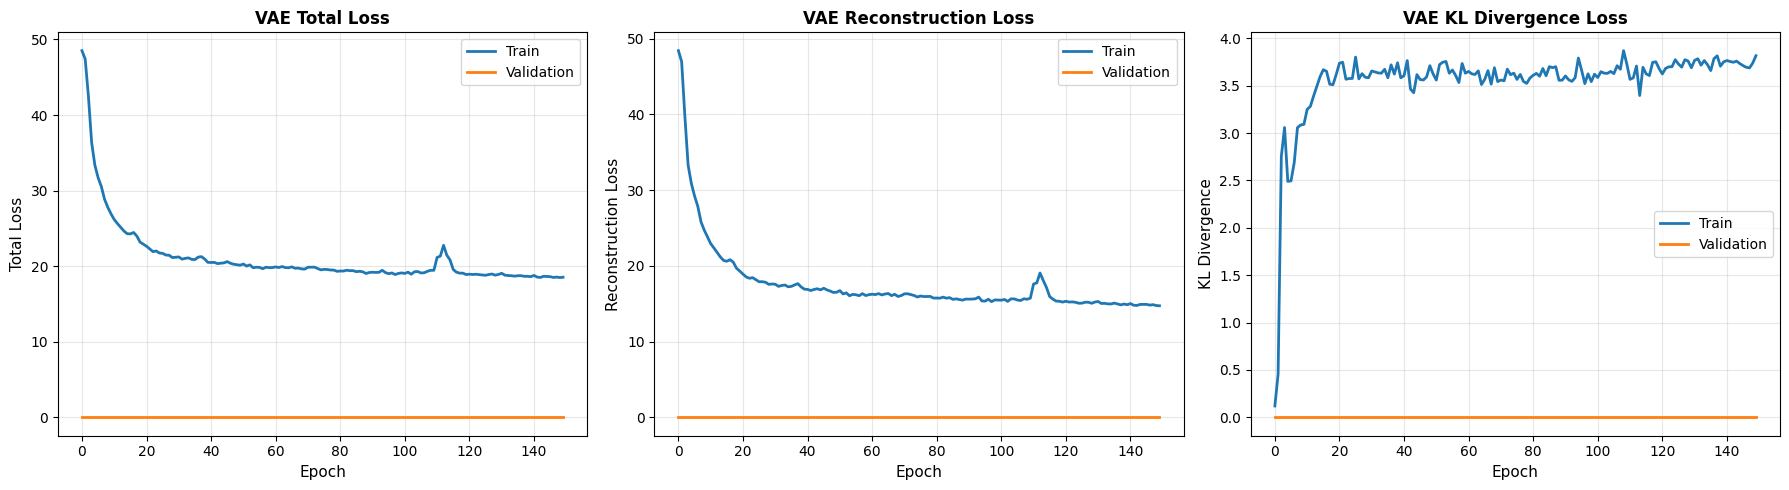

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Latent representation shape: (467, 2)
Latent mean per dimension: [0.06534901 0.05580411]
Latent std per dimension: [1.1061636 1.0568836]
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Mean reconstruction error: 0.3150
Std reconstruction error: 0.2876


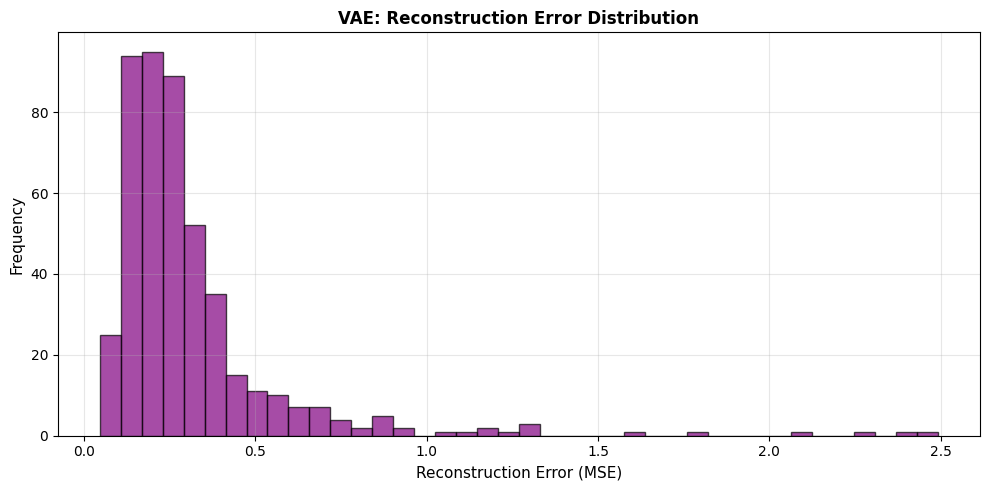

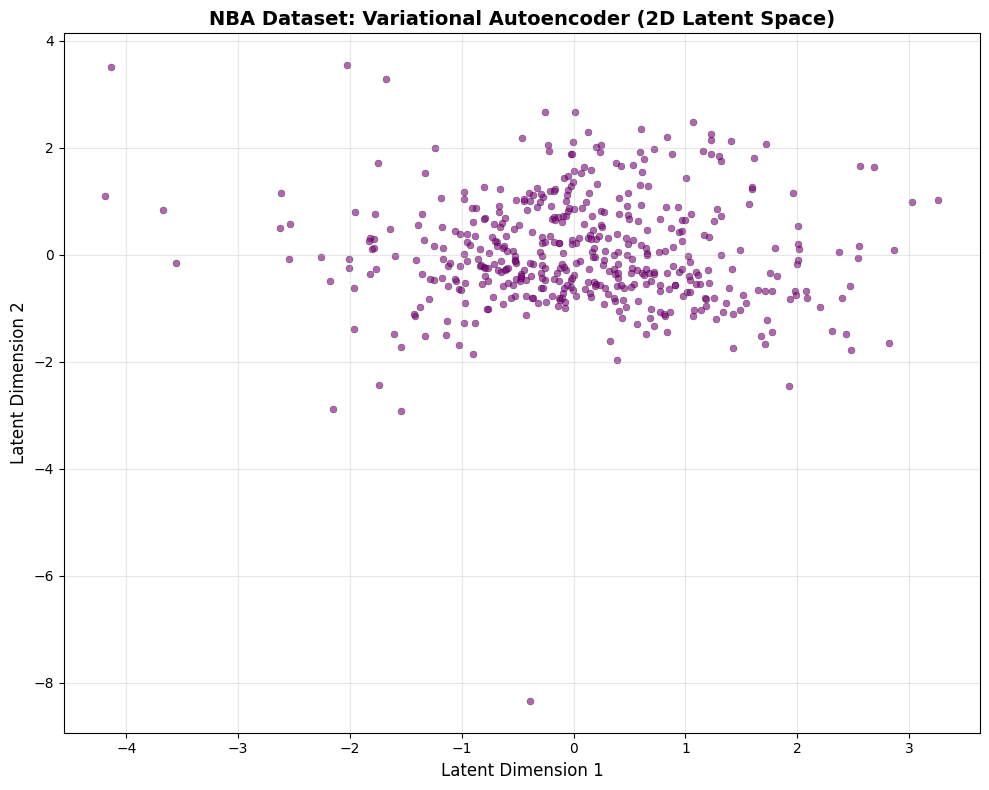

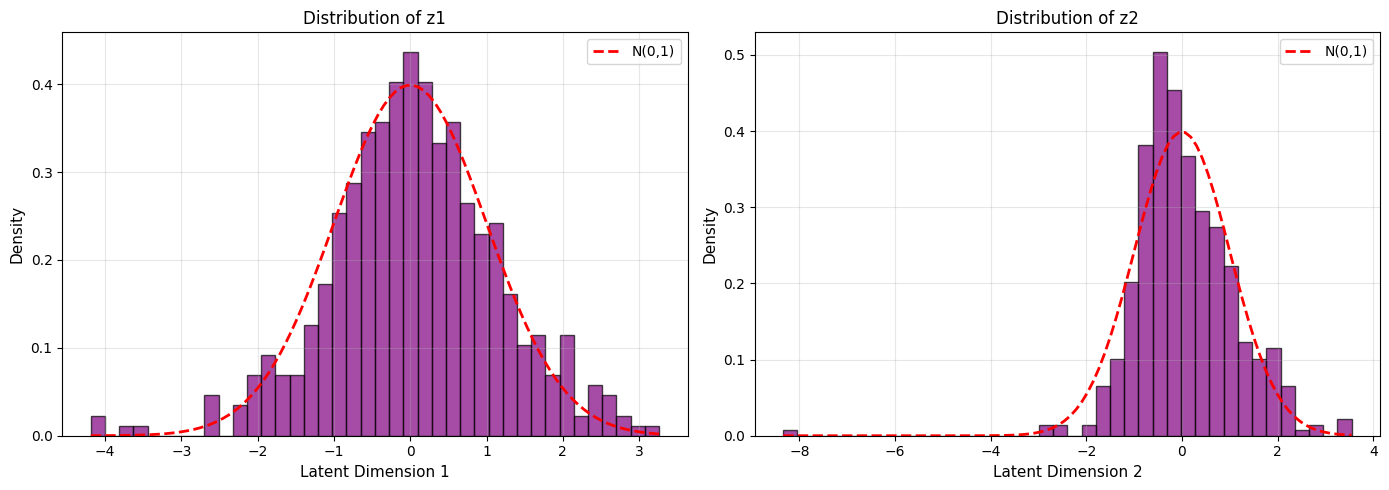

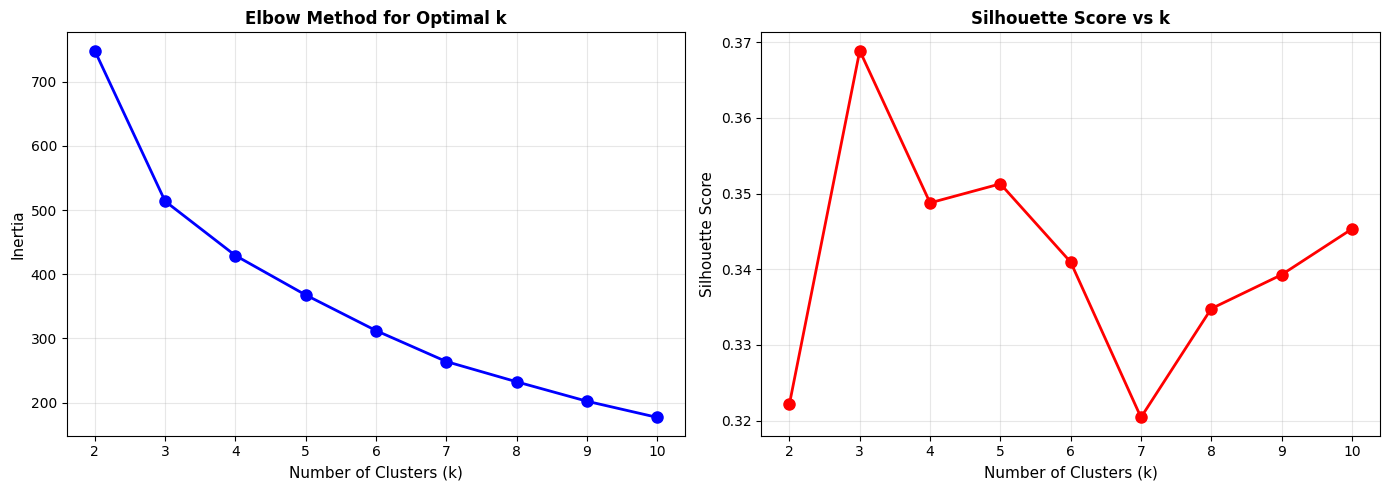

Silhouette scores by k:
  k=2: 0.3222
  k=3: 0.3689
  k=4: 0.3488
  k=5: 0.3513
  k=6: 0.3409
  k=7: 0.3204
  k=8: 0.3348
  k=9: 0.3393
  k=10: 0.3453

Cluster sizes (k=6):
  Cluster 0: 33 players
  Cluster 1: 129 players
  Cluster 2: 120 players
  Cluster 3: 1 players
  Cluster 4: 125 players
  Cluster 5: 59 players


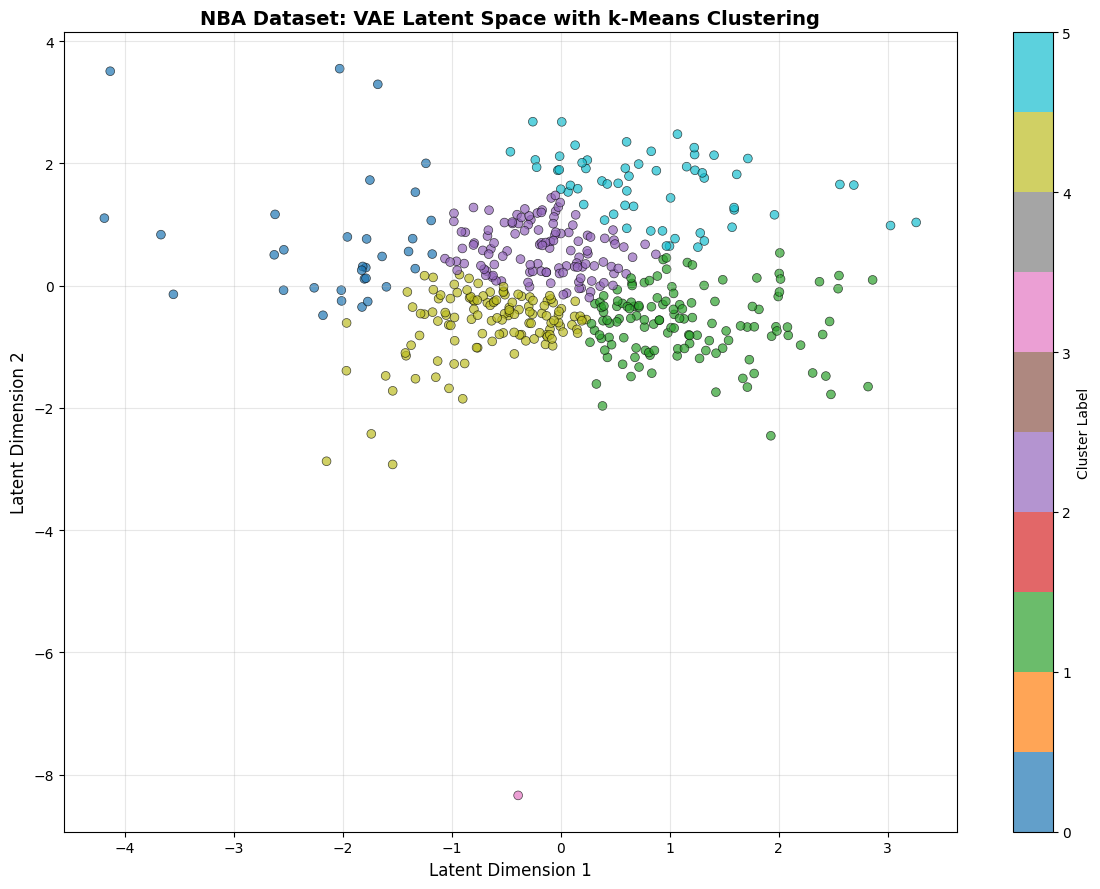


CLUSTER CHARACTERIZATION (Top 5 differentiating features by z-score)

--- Cluster 0 (n=33) ---
  Highest features (above average):
    Unnamed: 0  : +1.19σ
    TOV%        : +0.68σ
    3PAr        : +0.26σ
    ORB%        : +0.15σ
    USG%        : +0.01σ
  Lowest features (below average):
    eFG%        : -1.91σ
    BPM         : -1.93σ
    OBPM        : -1.98σ
    TS%         : -2.04σ
    WS/48       : -2.13σ

--- Cluster 1 (n=129) ---
  Highest features (above average):
    FGA         : +1.23σ
    PTS         : +1.18σ
    MP          : +1.16σ
    FG          : +1.14σ
    3PA         : +1.14σ
  Lowest features (below average):
    BLK%        : -0.27σ
    DRB%        : -0.28σ
    TRB%        : -0.43σ
    ORB%        : -0.50σ
    Unnamed: 0  : -0.84σ

--- Cluster 2 (n=120) ---
  Highest features (above average):
    Unnamed: 0  : +0.39σ
    ORB%        : +0.26σ
    2P%         : +0.22σ
    TRB%        : +0.21σ
    TOV%        : +0.20σ
  Lowest features (below average):
    PTS     

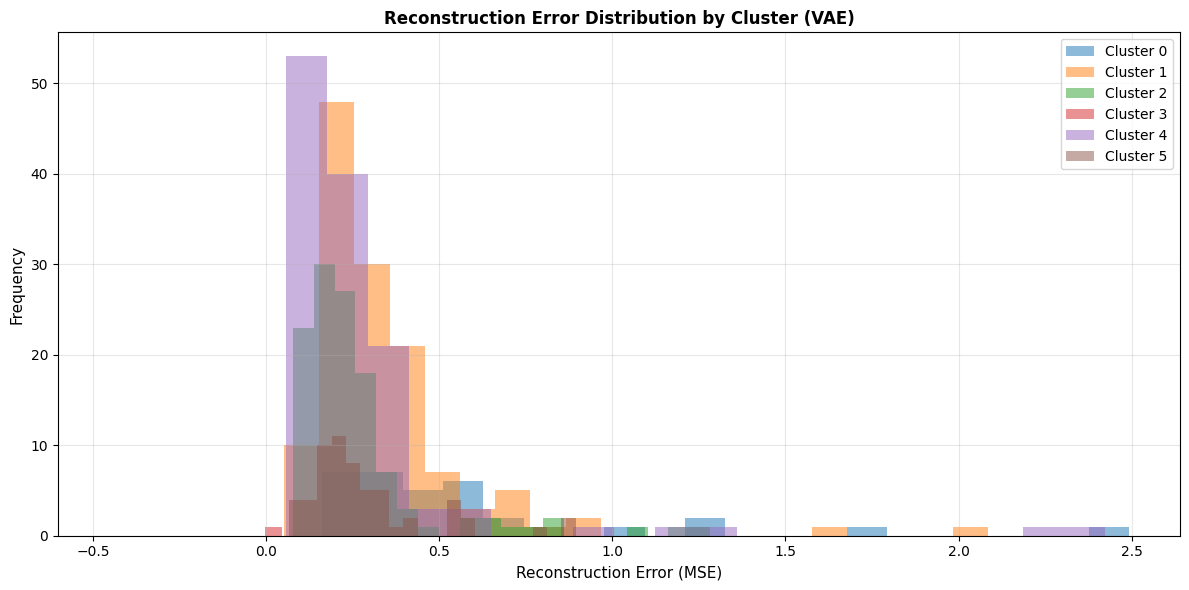

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Generated 400 synthetic player profiles from latent space grid

Synthetic data statistics (first 5 features):
  Unnamed: 0: mean=0.02, std=1.11
  Salary: mean=0.23, std=1.09
  Age: mean=0.12, std=0.37
  GP: mean=-0.36, std=1.07
  GS: mean=0.17, std=1.06


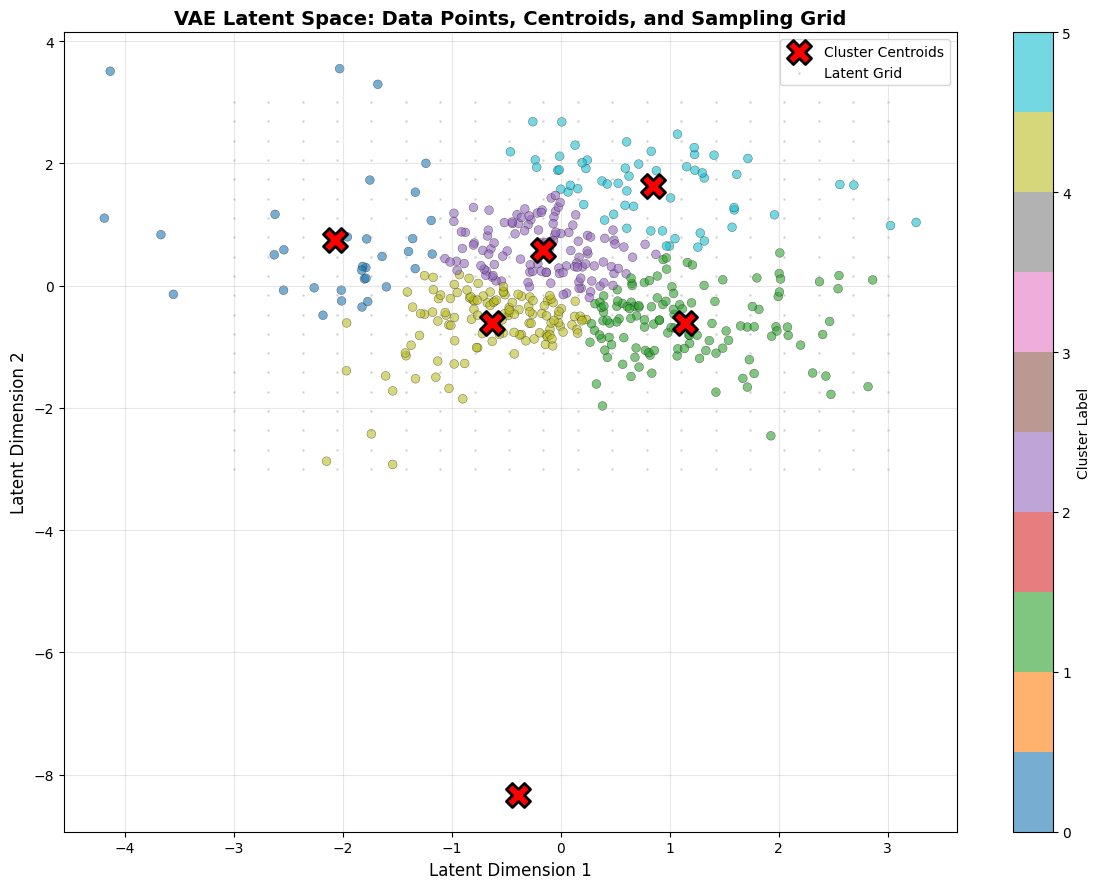

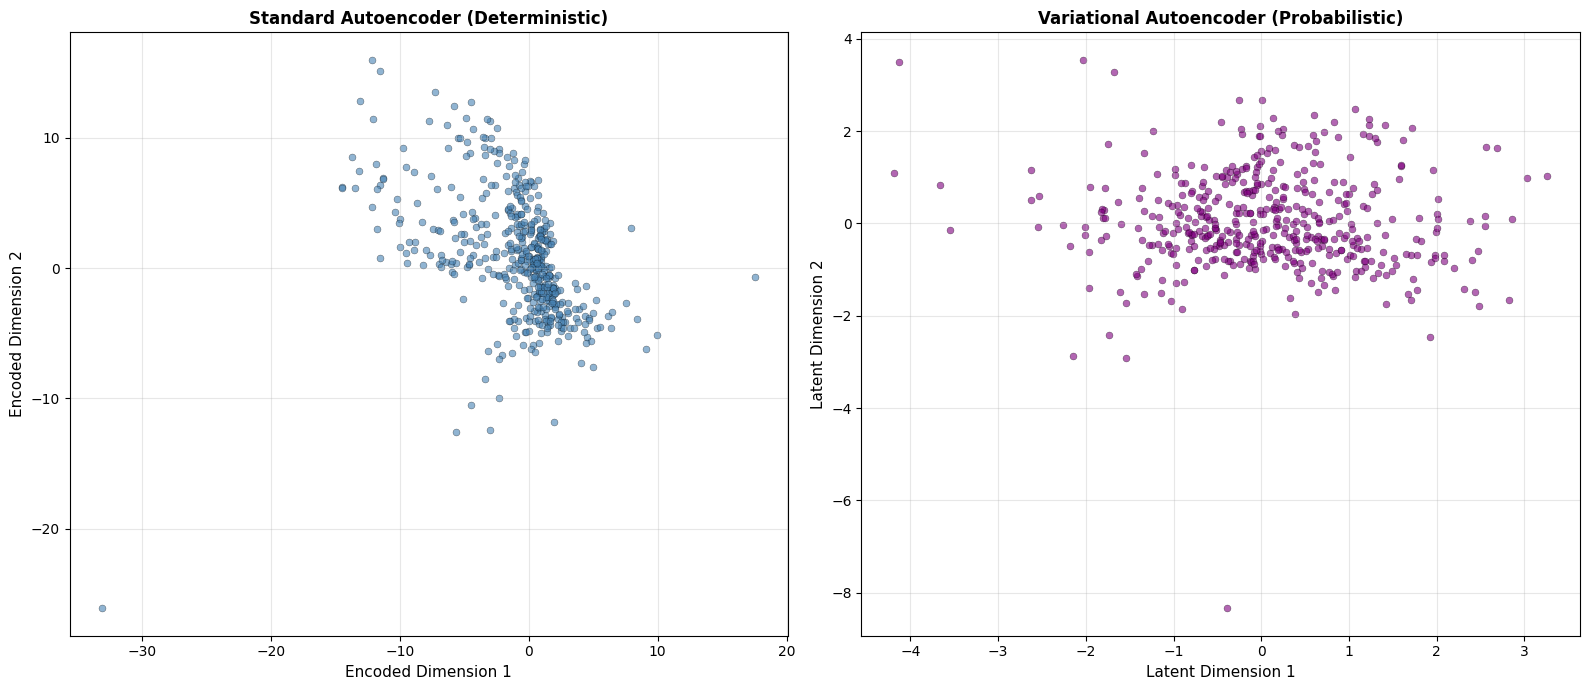

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


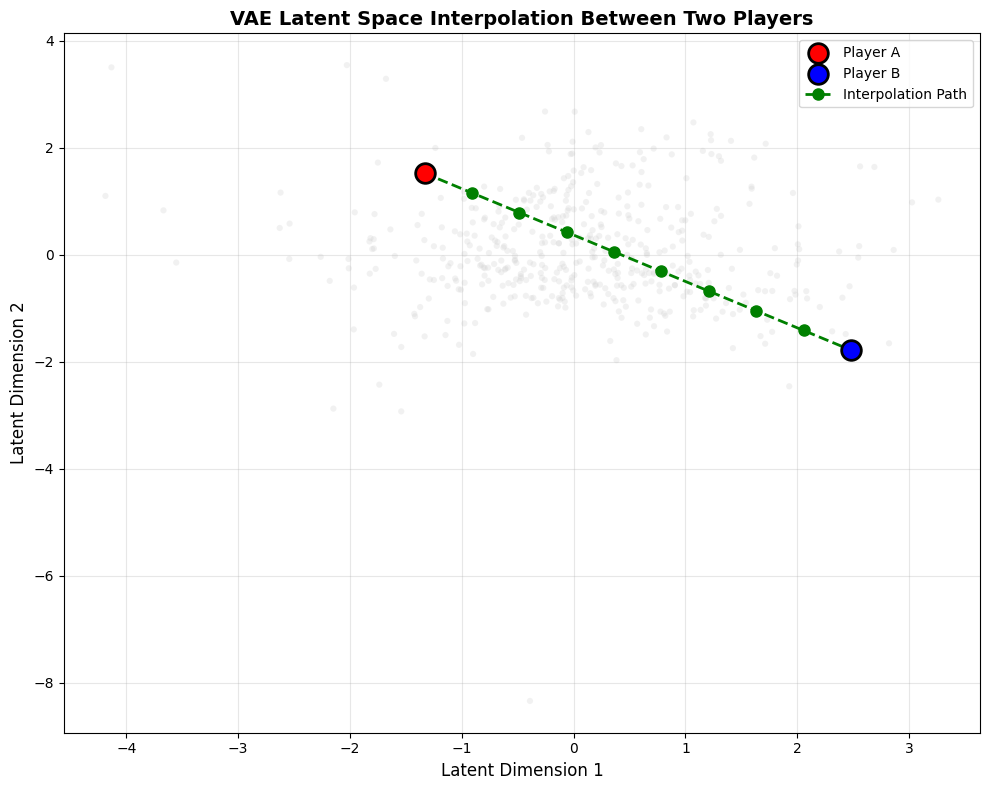


Interpolation between Player 448 and Player 18
Player A latent: [-1.3332658  1.527051 ]
Player B latent: [ 2.479011  -1.7800989]
Created 10 intermediate 'synthetic' players


In [347]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, backend as K
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Use the existing cleaned data (xScaled, xTrain, xTest from previous sections)

inputDimension = xTrain.shape[1]
latentDimension = 2  # Direct reduction to 2D for visualization

# Build Encoder
encoder_input = layers.Input(shape=(inputDimension,), name='encoder_input')
x = layers.Dense(128, activation='relu')(encoder_input)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)

# Instead of outputting latent directly, output mean and log_variance
z_mean = layers.Dense(latentDimension, name='z_mean')(x)
z_log_var = layers.Dense(latentDimension, name='z_log_var')(x)

# Sampling layer: uses reparameterization trick
# z = mean + exp(log_var/2) * epsilon, where epsilon ~ N(0,1)
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the latent vector."""
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Sampling()([z_mean, z_log_var])

# Create encoder model
encoder_vae = models.Model(encoder_input, [z_mean, z_log_var, z], name='encoder')

print("Encoder architecture:")
encoder_vae.summary()

# Build Decoder
latent_input = layers.Input(shape=(latentDimension,), name='latent_input')
x = layers.Dense(32, activation='relu')(latent_input)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
decoder_output = layers.Dense(inputDimension, activation='linear')(x)

# Create decoder model
decoder_vae = models.Model(latent_input, decoder_output, name='decoder')

print("\nDecoder architecture:")
decoder_vae.summary()

# Build complete VAE
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            # Reconstruction loss (MSE)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.square(data - reconstruction), axis=1
                )
            )
            
            # KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(
                    1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
                    axis=1
                )
            )
            
            # Total loss
            total_loss = reconstruction_loss + kl_loss
        
        # Compute gradients and update weights
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def test_step(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                tf.square(data - reconstruction), axis=1
            )
        )
        
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
                axis=1
            )
        )
        
        total_loss = reconstruction_loss + kl_loss
        
        return {
            "total_loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

# Instantiate VAE
vae = VAE(encoder_vae, decoder_vae)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

print("\nVAE model created successfully!")

# Train VAE
history_vae = vae.fit(
    xTrain, 
    epochs=150,
    batch_size=32,
    validation_data=xTest,  # Pass as single-element tuple
    verbose=1
)

# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Total loss
axes[0].plot(history_vae.history['total_loss'], label='Train', linewidth=2)
axes[0].plot(history_vae.history['val_total_loss'], label='Validation', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=11)
axes[0].set_ylabel('Total Loss', fontsize=11)
axes[0].set_title('VAE Total Loss', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Reconstruction loss
axes[1].plot(history_vae.history['reconstruction_loss'], label='Train', linewidth=2)
axes[1].plot(history_vae.history['val_reconstruction_loss'], label='Validation', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=11)
axes[1].set_ylabel('Reconstruction Loss', fontsize=11)
axes[1].set_title('VAE Reconstruction Loss', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# KL divergence loss
axes[2].plot(history_vae.history['kl_loss'], label='Train', linewidth=2)
axes[2].plot(history_vae.history['val_kl_loss'], label='Validation', linewidth=2)
axes[2].set_xlabel('Epoch', fontsize=11)
axes[2].set_ylabel('KL Divergence', fontsize=11)
axes[2].set_title('VAE KL Divergence Loss', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Get latent representations (use mean for deterministic embedding)
z_mean_all, z_log_var_all, z_sample_all = encoder_vae.predict(xScaled)

# Use z_mean for visualization (deterministic)
X_vae = z_mean_all

print(f"Latent representation shape: {X_vae.shape}")
print(f"Latent mean per dimension: {X_vae.mean(axis=0)}")
print(f"Latent std per dimension: {X_vae.std(axis=0)}")

# Calculate reconstruction error
X_reconstructed_vae = vae.predict(xScaled)
reconstruction_errors_vae = np.mean(np.square(xScaled - X_reconstructed_vae), axis=1)

print(f"Mean reconstruction error: {np.mean(reconstruction_errors_vae):.4f}")
print(f"Std reconstruction error: {np.std(reconstruction_errors_vae):.4f}")

# Plot reconstruction error distribution
plt.figure(figsize=(10, 5))
plt.hist(reconstruction_errors_vae, bins=40, color='purple', edgecolor='k', alpha=0.7)
plt.xlabel('Reconstruction Error (MSE)', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('VAE: Reconstruction Error Distribution', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Visualize the 2D latent space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_vae[:, 0], X_vae[:, 1], 
                     s=25, alpha=0.6, c='purple', 
                     edgecolors='k', linewidth=0.3)
plt.xlabel('Latent Dimension 1', fontsize=12)
plt.ylabel('Latent Dimension 2', fontsize=12)
plt.title('NBA Dataset: Variational Autoencoder (2D Latent Space)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Check if latent space follows approximate Gaussian distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i in range(2):
    axes[i].hist(X_vae[:, i], bins=40, density=True, alpha=0.7, color='purple', edgecolor='k')
    
    # Overlay theoretical N(0,1) for comparison
    x_range = np.linspace(X_vae[:, i].min(), X_vae[:, i].max(), 100)
    from scipy.stats import norm
    axes[i].plot(x_range, norm.pdf(x_range, 0, 1), 'r--', linewidth=2, label='N(0,1)')
    
    axes[i].set_xlabel(f'Latent Dimension {i+1}', fontsize=11)
    axes[i].set_ylabel('Density', fontsize=11)
    axes[i].set_title(f'Distribution of z{i+1}', fontsize=12)
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Determine optimal number of clusters
inertias_vae = []
silhouette_scores_vae = []
K_range = range(2, 11)

from sklearn.metrics import silhouette_score

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels_temp = kmeans_temp.fit_predict(X_vae)
    inertias_vae.append(kmeans_temp.inertia_)
    silhouette_scores_vae.append(silhouette_score(X_vae, labels_temp))

# Plot elbow curve and silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_range, inertias_vae, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[0].set_ylabel('Inertia', fontsize=11)
axes[0].set_title('Elbow Method for Optimal k', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(K_range, silhouette_scores_vae, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[1].set_ylabel('Silhouette Score', fontsize=11)
axes[1].set_title('Silhouette Score vs k', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Silhouette scores by k:")
for k, score in zip(K_range, silhouette_scores_vae):
    print(f"  k={k}: {score:.4f}")

# Apply k-Means with chosen k
k = 6  # Adjust based on elbow/silhouette analysis
kmeans_vae = KMeans(n_clusters=k, n_init=20, random_state=42)
labels_vae = kmeans_vae.fit_predict(X_vae)

# Cluster statistics
unique_labels, counts = np.unique(labels_vae, return_counts=True)
print(f"\nCluster sizes (k={k}):")
for label, count in zip(unique_labels, counts):
    print(f"  Cluster {label}: {count} players")

# Visualize clustered VAE latent space
plt.figure(figsize=(12, 9))
scatter = plt.scatter(
    X_vae[:, 0], X_vae[:, 1],
    c=labels_vae,
    cmap='tab10',
    s=40,
    alpha=0.7,
    edgecolors='k',
    linewidth=0.5
)
plt.colorbar(scatter, label='Cluster Label', ticks=range(k))
plt.xlabel('Latent Dimension 1', fontsize=12)
plt.ylabel('Latent Dimension 2', fontsize=12)
plt.title('NBA Dataset: VAE Latent Space with k-Means Clustering', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Add cluster labels to the dataframe
dfAnalysis = dfCleaned.copy()
dfAnalysis['Cluster_VAE'] = labels_vae

# Statistical summary by cluster
numeric_cols = dfCleaned.select_dtypes(include=[np.number]).columns
cluster_summary = dfAnalysis.groupby('Cluster_VAE')[numeric_cols].mean()

# Calculate z-scores relative to global mean
global_mean = dfAnalysis[numeric_cols].mean()
global_std = dfAnalysis[numeric_cols].std()
cluster_zscore = (cluster_summary - global_mean) / global_std

# Display top differentiating features per cluster
print("\n" + "="*80)
print("CLUSTER CHARACTERIZATION (Top 5 differentiating features by z-score)")
print("="*80)

for cluster_id in range(k):
    print(f"\n--- Cluster {cluster_id} (n={counts[cluster_id]}) ---")
    z = cluster_zscore.loc[cluster_id].sort_values(ascending=False)
    
    print("  Highest features (above average):")
    for feat, val in z.head(5).items():
        print(f"    {feat:12s}: {val:+.2f}σ")
    
    print("  Lowest features (below average):")
    for feat, val in z.tail(5).items():
        print(f"    {feat:12s}: {val:+.2f}σ")

# Show example players from each cluster
print("\n" + "="*80)
print("EXAMPLE PLAYERS PER CLUSTER")
print("="*80)

for cluster_id in range(k):
    cluster_players = dfAnalysis[dfAnalysis['Cluster_VAE'] == cluster_id]
    
    # Sample random players or top by a metric
    if 'Player Name' in dfCleaned.columns and 'PTS' in dfCleaned.columns:
        sample = cluster_players.nlargest(5, 'PTS')[['Player Name', 'PTS', 'Age', 'MP']]
        print(f"\nCluster {cluster_id} - Top 5 by PTS:")
        print(sample.to_string(index=False))

# Reconstruction error by cluster
recon_by_cluster = pd.DataFrame({
    'Cluster': labels_vae,
    'Reconstruction_Error': reconstruction_errors_vae
})

print("\n" + "="*80)
print("RECONSTRUCTION ERROR BY CLUSTER")
print("="*80)
print(recon_by_cluster.groupby('Cluster')['Reconstruction_Error'].describe())

# Visualize reconstruction error distribution by cluster
plt.figure(figsize=(12, 6))
for cluster_id in range(k):
    cluster_errors = recon_by_cluster[recon_by_cluster['Cluster'] == cluster_id]['Reconstruction_Error']
    plt.hist(cluster_errors, bins=20, alpha=0.5, label=f'Cluster {cluster_id}')

plt.xlabel('Reconstruction Error (MSE)', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Reconstruction Error Distribution by Cluster (VAE)', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Create a grid in latent space
n_grid = 20
grid_x = np.linspace(-3, 3, n_grid)
grid_y = np.linspace(-3, 3, n_grid)

# Sample points from the grid
sampled_points = []
for x in grid_x:
    for y in grid_y:
        sampled_points.append([x, y])

sampled_points = np.array(sampled_points)

# Decode the sampled points
decoded_samples = decoder_vae.predict(sampled_points)

print(f"Generated {len(decoded_samples)} synthetic player profiles from latent space grid")

# Show some statistics of decoded samples
print("\nSynthetic data statistics (first 5 features):")
feature_names = dfCleaned.select_dtypes(include=[np.number]).columns[:5]
for i, feat in enumerate(feature_names):
    print(f"  {feat}: mean={decoded_samples[:, i].mean():.2f}, std={decoded_samples[:, i].std():.2f}")

# Visualize latent space with cluster boundaries
plt.figure(figsize=(12, 9))

# Plot cluster centroids
centroids = kmeans_vae.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], 
           c='red', marker='X', s=300, edgecolors='black', 
           linewidth=2, label='Cluster Centroids', zorder=10)

# Plot data points colored by cluster
scatter = plt.scatter(X_vae[:, 0], X_vae[:, 1],
                     c=labels_vae, cmap='tab10',
                     s=40, alpha=0.6, edgecolors='k', linewidth=0.3)

# Plot grid samples (faintly) to show coverage
plt.scatter(sampled_points[:, 0], sampled_points[:, 1],
           c='gray', marker='.', s=5, alpha=0.2, label='Latent Grid')

plt.colorbar(scatter, label='Cluster Label', ticks=range(k))
plt.xlabel('Latent Dimension 1', fontsize=12)
plt.ylabel('Latent Dimension 2', fontsize=12)
plt.title('VAE Latent Space: Data Points, Centroids, and Sampling Grid', 
         fontsize=14, fontweight='bold')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot standard AE (if X_encoded exists from earlier)
if 'X_encoded' in globals():
    axes[0].scatter(X_encoded[:, 0], X_encoded[:, 1], 
                   s=25, alpha=0.6, c='steelblue', edgecolors='k', linewidth=0.3)
    axes[0].set_xlabel('Encoded Dimension 1', fontsize=11)
    axes[0].set_ylabel('Encoded Dimension 2', fontsize=11)
    axes[0].set_title('Standard Autoencoder (Deterministic)', fontsize=12, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
else:
    axes[0].text(0.5, 0.5, 'Standard AE not available\nRun Question 2.1(a) first', 
                ha='center', va='center', transform=axes[0].transAxes, fontsize=12)
    axes[0].set_title('Standard Autoencoder', fontsize=12, fontweight='bold')

# Plot VAE
axes[1].scatter(X_vae[:, 0], X_vae[:, 1], 
               s=25, alpha=0.6, c='purple', edgecolors='k', linewidth=0.3)
axes[1].set_xlabel('Latent Dimension 1', fontsize=11)
axes[1].set_ylabel('Latent Dimension 2', fontsize=11)
axes[1].set_title('Variational Autoencoder (Probabilistic)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Demonstrate interpolation between two players
# Pick two random players from different clusters

cluster_pairs = [(labels_vae == i) for i in range(min(2, k))]
if len(cluster_pairs) >= 2:
    idx1 = np.random.choice(np.where(cluster_pairs[0])[0])
    idx2 = np.random.choice(np.where(cluster_pairs[1])[0])
    
    z1 = X_vae[idx1]
    z2 = X_vae[idx2]
    
    # Create interpolation
    n_steps = 10
    alphas = np.linspace(0, 1, n_steps)
    interpolated_z = np.array([alpha * z2 + (1 - alpha) * z1 for alpha in alphas])
    
    # Decode interpolated points
    interpolated_decoded = decoder_vae.predict(interpolated_z)
    
    # Visualize interpolation path
    plt.figure(figsize=(10, 8))
    plt.scatter(X_vae[:, 0], X_vae[:, 1], 
               c='lightgray', s=20, alpha=0.3, edgecolors='none')
    plt.scatter(z1[0], z1[1], c='red', s=200, marker='o', 
               edgecolors='black', linewidth=2, label='Player A', zorder=10)
    plt.scatter(z2[0], z2[1], c='blue', s=200, marker='o', 
               edgecolors='black', linewidth=2, label='Player B', zorder=10)
    plt.plot(interpolated_z[:, 0], interpolated_z[:, 1], 
            'g--', linewidth=2, marker='o', markersize=8, 
            label='Interpolation Path', zorder=5)
    
    plt.xlabel('Latent Dimension 1', fontsize=12)
    plt.ylabel('Latent Dimension 2', fontsize=12)
    plt.title('VAE Latent Space Interpolation Between Two Players', 
             fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\nInterpolation between Player {idx1} and Player {idx2}")
    print(f"Player A latent: {z1}")
    print(f"Player B latent: {z2}")
    print(f"Created {n_steps} intermediate 'synthetic' players")